In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgridspec
from genome_tools.plotting import sequence
import seaborn as sns
import h5py as h5
import vizsequence
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

#### This notebook is using the original approach and scripts provided by Vierstra lab: https://github.com/vierstralab/motif-clustering/

In [5]:
def extract_pwm(sample, pwm_id):
    with open(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco/{sample}_hg38.modisco_results.meme') as f:
        pwms = f.read()

    pwm_to_extract = pwms.split(pwm_id)[1].split('MOTIF')[0].split('\n')
    pwm_to_extract = [x.lstrip(' ').split() for x in pwm_to_extract if x != ''][1:]
    pwm_to_extract = pd.DataFrame(pwm_to_extract)
    for i in range(4):
        pwm_to_extract[i] = [float(x) for x in pwm_to_extract[i]]
    pwm_to_extract = pwm_to_extract.values
    return(pwm_to_extract)

def relative_info_content(pwm):
    p = pwm/np.sum(pwm, axis = 1)[:,np.newaxis]
    ic = 2+np.sum(p*np.nan_to_num(np.log2(p)), axis = 1)
    ric = p*ic[:,np.newaxis]
    return(ric)

def plot_pwm(pwm):
    w = pwm.shape[0]

    fig = plt.figure()
    fig.set_size_inches(w*0.125, 0.5)

    figw, figh = fig.get_size_inches() 

    gs = mgridspec.GridSpec(1, 1)
    gs.update(left=0, right=1, top=1, bottom=0)

    ax = fig.add_subplot(gs[:,:])

    sequence.seq_plot(relative_info_content(pwm), ax=ax)

    ax.set_xlim(left=0, right=w)
    ax.set_ylim(bottom=0, top=2.1)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]

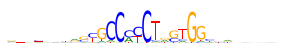

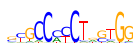

In [6]:
# read pwm
pwm = extract_pwm('NA12878', 'pattern_0')
plot_pwm(pwm)

# trim pwm
ic = relative_info_content(pwm)
total_ic = ic.sum(axis = 1)
cdf = np.cumsum(total_ic)/np.sum(total_ic)
s = np.where(cdf > 0.05)[0][0]
e = np.where(cdf > 0.95)[0][0] + 1    
pwm_trimmed = pwm[s:e,:]
plot_pwm(pwm_trimmed)

In [7]:
pwm = extract_pwm('NA12878', 'pattern_0')
ic = relative_info_content(pwm)
total_ic = ic.sum(axis=1)

cdf = np.cumsum(total_ic)/np.sum(total_ic)
s = np.where(cdf > 0.05)[0][0]
e = np.where(cdf > 0.95)[0][0] + 1 

cdf

array([0.00907771, 0.01194836, 0.01286826, 0.02211126, 0.02390808,
       0.02709576, 0.03376079, 0.04833977, 0.07176223, 0.10819219,
       0.16421662, 0.24518797, 0.36047165, 0.40693224, 0.46691167,
       0.58793042, 0.67052974, 0.68893797, 0.73484939, 0.78665097,
       0.90308992, 0.96630836, 0.98059696, 0.98461902, 0.99529959,
       0.99543484, 0.9969732 , 0.99735718, 0.99833304, 1.        ])

## Prepare table with motifs

In [8]:
def get_cluster_by_id(motif_id, jaspar_clusters):
    jaspar_clusters_for_motif = jaspar_clusters[jaspar_clusters[1].isin([x for x in jaspar_clusters[1] if motif_id in x])]
    if len(jaspar_clusters_for_motif[0].values) == 1:
        return(jaspar_clusters_for_motif[0].values[0])
    else:
        return(np.nan)
    
def extract_motif_matches(sample, qval_thresh = 0.1):
    motif_matches = pd.read_html(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco/report_{sample}/motifs.html')[0]
    motif_matches = motif_matches[['pattern', 'num_seqlets', 
                                   'match0', 'qval0', 'match1', 'qval1', 'match2', 'qval2', 'match3', 'qval3', 'match4', 'qval4']]
    motif_matches = motif_matches[motif_matches['pattern'].isin([x for x in motif_matches['pattern'] if 'neg_pattern' not in x])]
    motif_matches['pattern'] = [sample + '_' + x.replace('pos_patterns.', '') for x in motif_matches['pattern']]
    
    for i in range(0, 5):
        motif_matches[f'motif{i}'] = [jaspar_motifs[jaspar_motifs['id'] == x]['name'].values[0] if x in jaspar_motifs['id'].values and y<qval_thresh else np.nan for (x, y) in zip(motif_matches[f'match{i}'], motif_matches[f'qval{i}'])]
        motif_matches[f'cluster{i}'] = [get_cluster_by_id(x, jaspar_clusters) if y<qval_thresh else np.nan for (x, y) in zip(motif_matches[f'match{i}'], motif_matches[f'qval{i}'])]
        motif_matches[f'match{i}'] = [x if y<qval_thresh else np.nan for (x, y) in zip(motif_matches[f'match{i}'], motif_matches[f'qval{i}'])]
        motif_matches[f'qval{i}'] = [x if x<qval_thresh else np.nan for x in motif_matches[f'qval{i}']]

    motif_matches = motif_matches[['pattern', 'num_seqlets', 
                                   'match0', 'motif0', 'cluster0', 'qval0', 'match1', 'motif1', 'cluster1', 'qval1', 
                                   'match2', 'motif2', 'cluster2', 'qval2', 'match3', 'motif3', 'cluster3', 'qval3', 
                                   'match4', 'motif4', 'cluster4', 'qval4']]
    return(motif_matches)

def find_cluster_per_motif_match(motif_matches):
    cluster_assignment = []
    for pattern in motif_matches[['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4']].values:
        pattern = list(pattern[~pd.isnull(pattern)])
        if len(pattern) != 0:
            scores = []
            for (i, element) in enumerate(pattern):
                count = len([x for x in pattern if x == element])
                rank = len(pattern)-i
                scores.append(count*rank)
            cluster_assignment.append(pattern[scores.index(max(scores))])
        else:
            cluster_assignment.append(np.nan)
    return(cluster_assignment)

In [9]:
with open("/DATA/databases/JASPAR2024/JASPAR2024_CORE_vertebrates_redundant_pfms_meme.txt") as motifs:
    jaspar_motifs = motifs.readlines()
jaspar_motifs = [x.replace('MOTIF ', '').rstrip('\n').split() for x in jaspar_motifs if 'MOTIF ' in x]
jaspar_motifs = pd.DataFrame(jaspar_motifs, columns = ['id', 'name'])
jaspar_motifs.head()

id       name
0  MA0002.1      RUNX1
1  MA0003.1     TFAP2A
2  MA0004.1       Arnt
3  MA0006.1  Ahr::Arnt
4  MA0007.1         Ar

In [10]:
with open("/DATA/users/m.magnitov/hap_phen/chromBPNet/JASPAR2024_CORE_vertebrates.motif_clusters.tab") as clusters:
    jaspar_clusters = clusters.readlines()
    
jaspar_clusters = [x.rstrip('\n').split('\t') for x in jaspar_clusters[1:]]
jaspar_clusters = pd.DataFrame(jaspar_clusters)
jaspar_clusters[1] = [",".join([y.split('_')[0] for y in x.replace('JASPAR_vertebrates_CORE_', '').split(',')]) for x in jaspar_clusters[1].values]
jaspar_clusters[2] = [",".join([y.split('_')[0] for y in x.split(',')]) for x in jaspar_clusters[2].values]
jaspar_clusters.head()

0                                                  1  \
0  cluster_001  MA0610.2,MA1478.2,MA1479.2,MA1707.2,MA0111.1,M...   
1  cluster_003       MA1712.2,MA1643.2,MA1527.2,MA0119.1,MA1528.2   
2  cluster_004  MA1645.2,MA0063.3,MA1523.2,MA1994.2,MA0672.2,M...   
3  cluster_005  MA0799.3,MA1554.2,MA1724.2,MA2334.1,MA0509.3,M...   
4  cluster_006  MA0041.3,MA0847.4,MA1487.3,MA1607.2,MA0846.2,M...   

                                                   2  
0  DMRT3,DMRTA2,DMRTC2,DMRTA1,Spz1,Six3,PKNOX1,PB...  
1                   ZNF454,NFIB,NFIC,NFIC::TLX1,NFIX  
2  NKX2-2,NKX2-5,MSANTD3,Nkx2-1,NKX2-3,NKX2-8,NKX...  
3          RFX4,RFX7,Rfx6,ZNF547,RFX1,RFX3,RFX5,RFX2  
4  FOXD3,FOXD2,FOXE1,Foxl2,FOXC2,FOXC1,FOXB1,BARH...

In [11]:
modisco_motifs_data = []

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    modisco_sample = extract_motif_matches(sample + '_hg38')
    modisco_sample['best_cluster'] = find_cluster_per_motif_match(modisco_sample)
    modisco_sample['sample'] = [sample]*len(modisco_sample)
    modisco_motifs_data = modisco_motifs_data + list(modisco_sample.values)
    
modisco_motifs_data = pd.DataFrame(modisco_motifs_data)
modisco_motifs_data.columns = ['motif_id', 'num_seqlets', 
                               'match0', 'motif0', 'cluster0', 'qval0', 'match1', 'motif1', 'cluster1', 'qval1', 
                               'match2', 'motif2', 'cluster2', 'qval2', 'match3', 'motif3', 'cluster3', 'qval3', 
                               'match4', 'motif4', 'cluster4', 'qval4', 'best_cluster', 'sample']
modisco_motifs_data = modisco_motifs_data[['motif_id', 'sample', 'num_seqlets', 'best_cluster',
                                           'match0', 'motif0', 'cluster0', 'qval0', 'match1', 'motif1', 'cluster1', 'qval1', 
                                           'match2', 'motif2', 'cluster2', 'qval2', 'match3', 'motif3', 'cluster3', 'qval3', 
                                           'match4', 'motif4', 'cluster4', 'qval4']]

modisco_motifs_data['motif_id'] = [x.replace('hg38_', '') for x in modisco_motifs_data['motif_id'].values]

modisco_motifs_data

motif_id   sample  num_seqlets best_cluster    match0  \
0     NA12878_pattern_0  NA12878        16242  cluster_017  MA0139.2   
1     NA12878_pattern_1  NA12878        11647  cluster_041  MA0517.2   
2     NA12878_pattern_2  NA12878        10803          NaN       NaN   
3     NA12878_pattern_3  NA12878        10785  cluster_001  MA0462.3   
4     NA12878_pattern_4  NA12878         7235  cluster_010  MA0081.3   
..                  ...      ...          ...          ...       ...   
236  HG03464_pattern_42  HG03464           58  cluster_063  MA0106.3   
237  HG03464_pattern_43  HG03464           52  cluster_063  MA0861.2   
238  HG03464_pattern_44  HG03464           37  cluster_065  MA1716.2   
239  HG03464_pattern_45  HG03464           25  cluster_001  MA0476.2   
240  HG03464_pattern_46  HG03464           20          NaN       NaN   

           motif0     cluster0         qval0    match1  motif1  ...  \
0            CTCF  cluster_017  1.438000e-13  MA1929.2    CTCF  ...   
1    STAT1::STAT2  cluster_041  2.022960e-02  MA0050.4    Irf1  ...   
2             NaN          NaN           NaN       NaN     NaN  ...   
3       BATF::JUN  cluster_001  7.478780e-04  MA0835.3   BATF3  ...   
4            SPIB  cluster_010  9.831650e-08  MA0080.7    Spi1  ...   
..            ...          ...           ...       ...     ...  ...   
236          TP53  cluster_063  4.263340e-04  MA0861.2    TP73  ...   
237          TP73  cluster_063  4.820210e-05  MA0106.3    TP53  ...   
238         ZNF76  cluster_065  3.913340e-04  MA0088.2  ZNF143  ...   
239           FOS  cluster_001  8.656980e-05  MA0655.1    JDP2  ...   
240           NaN          NaN           NaN       NaN     NaN  ...   

        cluster2         qval2    match3     motif3     cluster3     qval3  \
0    cluster_128  1.813630e-12  MA1102.3      CTCFL  cluster_017  0.031351   
1    cluster_041  2.152280e-02  MA0051.2       IRF2  cluster_041  0.021523   
2            NaN           NaN       NaN        NaN          NaN       NaN   
3    cluster_001  7.478780e-04  MA1988.2       Atf3  cluster_001  0.000748   
4    cluster_010  2.952050e-03  MA0474.4        Erg  cluster_010  0.002952   
..           ...           ...       ...        ...          ...       ...   
236          NaN           NaN       NaN        NaN          NaN       NaN   
237  cluster_056  1.096560e-02  MA1557.1      SMAD5  cluster_056  0.010966   
238          NaN           NaN       NaN        NaN          NaN       NaN   
239  cluster_001  8.656980e-05  MA1134.2  FOS::JUNB  cluster_001  0.000087   
240          NaN           NaN       NaN        NaN          NaN       NaN   

       match4 motif4     cluster4     qval4  
0         NaN    NaN          NaN       NaN  
1    MA0653.1   IRF9  cluster_041  0.023465  
2         NaN    NaN          NaN       NaN  
3    MA1928.2   BNC2  cluster_001  0.000748  
4    MA0598.4    EHF  cluster_010  0.006914  
..        ...    ...          ...       ...  
236       NaN    NaN          NaN       NaN  
237  MA0525.2   TP63  cluster_063  0.030198  
238       NaN    NaN          NaN       NaN  
239  MA0490.3   JUNB  cluster_001  0.000087  
240       NaN    NaN          NaN       NaN  

[241 rows x 24 columns]

## Plot all motifs to identify ambigous/repetitive ones

In [12]:
def plot_pattern(pattern_id):
    sample = pattern_id.split('_')[0]
    pattern = '_'.join(pattern_id.split('_')[1:])
    fh = h5.File(f"/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco/{sample}_hg38.modisco_results.h5")
    pattern_matrix = pd.DataFrame(list(fh['pos_patterns'][pattern]['contrib_scores']))
    print(sample + '_hg38_' + pattern, list(fh['pos_patterns'][pattern]['seqlets']['n_seqlets'])[0])
    print(len([x for x in np.sum(list(fh['pos_patterns'][pattern]['contrib_scores']), axis = 1) if x<0]))
    vizsequence.plot_weights(fh['pos_patterns'][pattern]['contrib_scores'])
    fh.close()

NA18983_hg38_pattern_0 17283
0


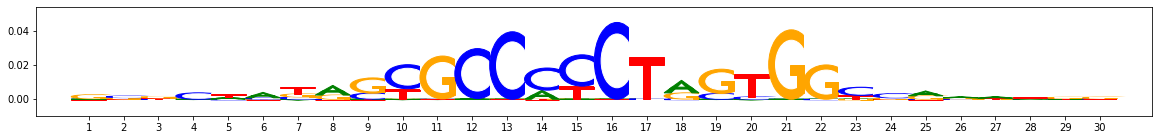

NA18983_hg38_pattern_1 14671
0


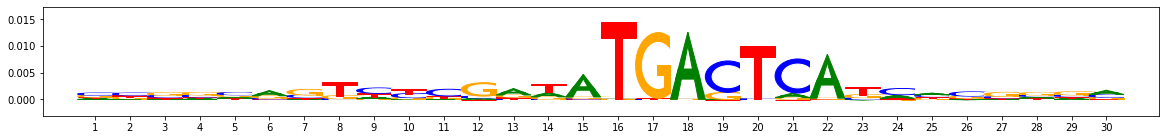

NA18983_hg38_pattern_10 1835
0


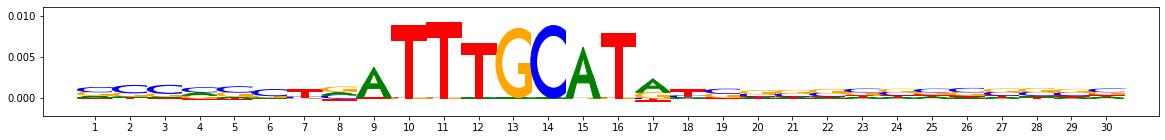

NA18983_hg38_pattern_11 1477
0


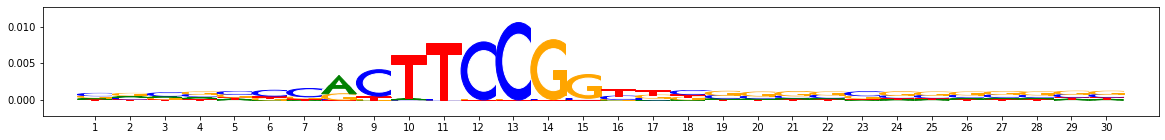

NA18983_hg38_pattern_12 1341
0


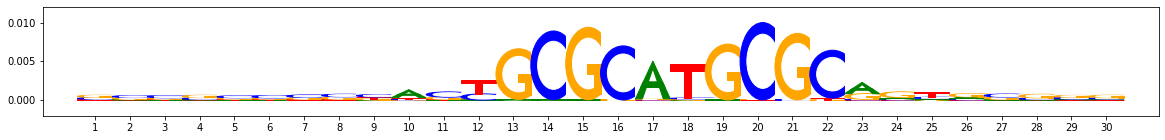

NA18983_hg38_pattern_13 1211
0


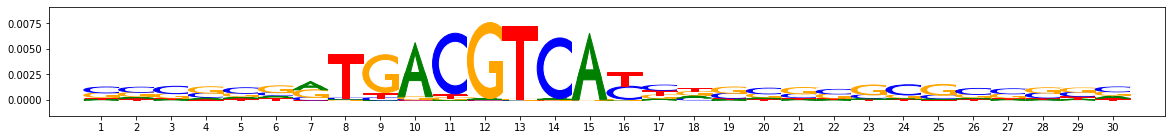

NA18983_hg38_pattern_14 1156
0


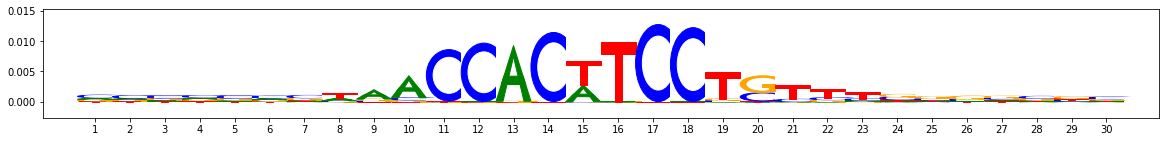

NA18983_hg38_pattern_15 1081
0


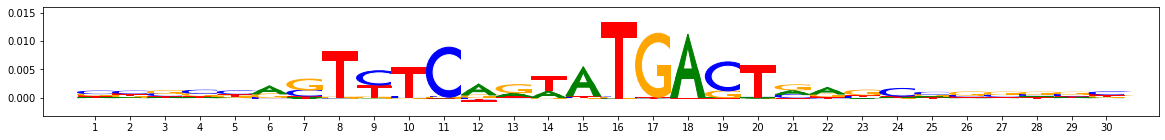

NA18983_hg38_pattern_16 979
0


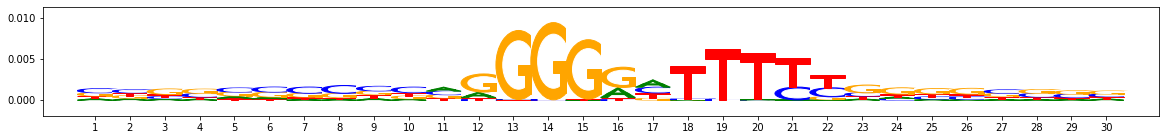

NA18983_hg38_pattern_17 967
0


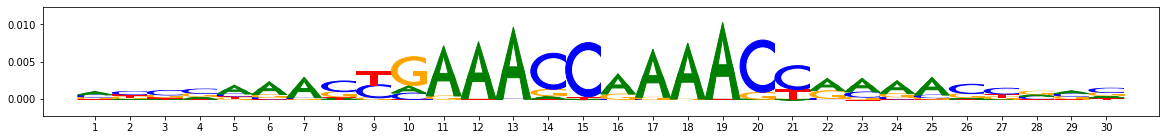

NA18983_hg38_pattern_18 930
0


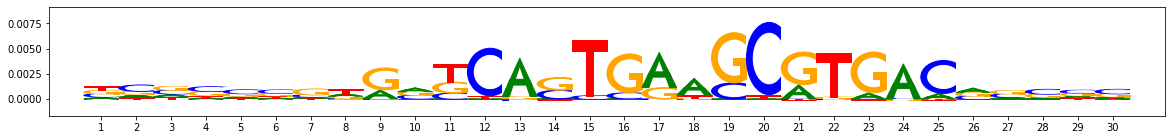

NA18983_hg38_pattern_19 901
0


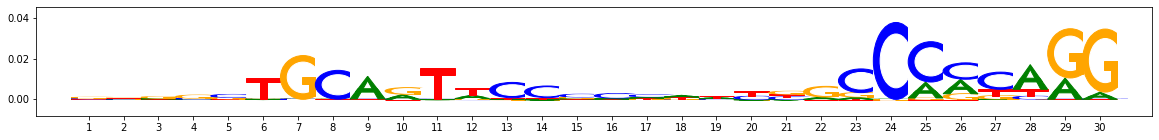

NA18983_hg38_pattern_2 13686
0


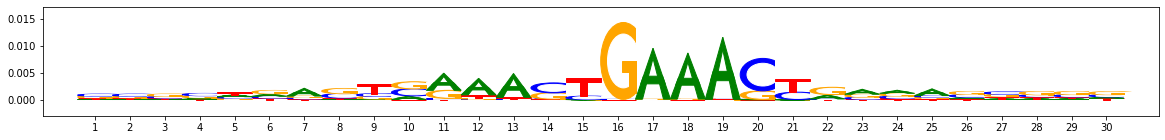

NA18983_hg38_pattern_20 888
0


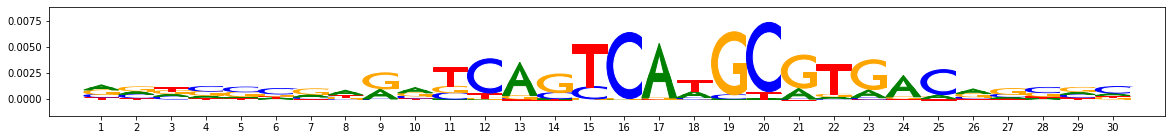

NA18983_hg38_pattern_21 856
0


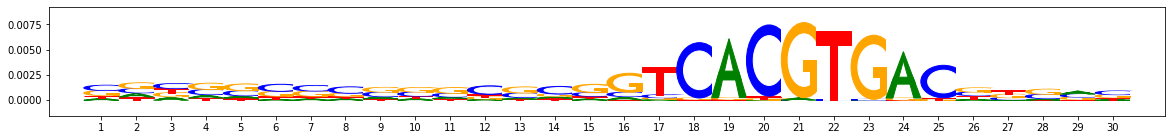

NA18983_hg38_pattern_22 739
0


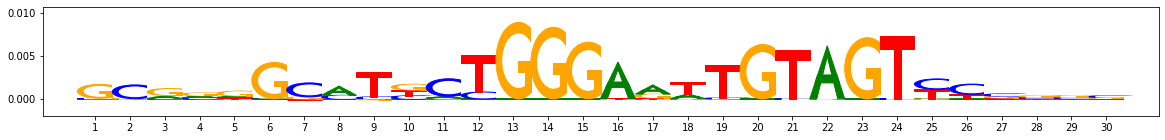

NA18983_hg38_pattern_23 723
2


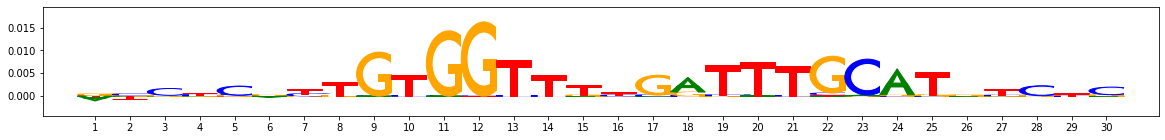

NA18983_hg38_pattern_24 719
0


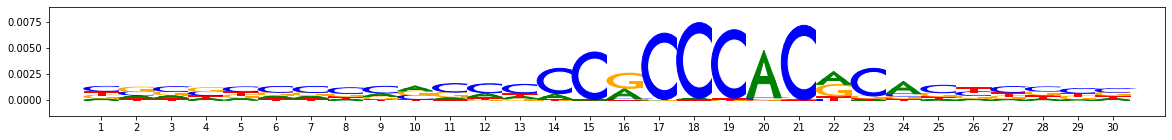

NA18983_hg38_pattern_25 714
0


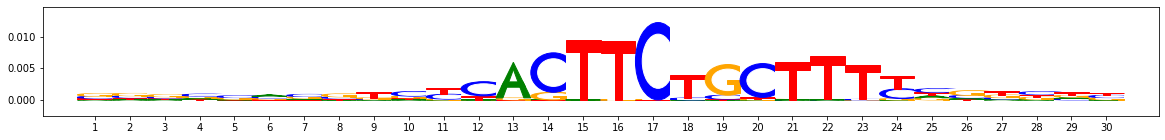

NA18983_hg38_pattern_26 517
0


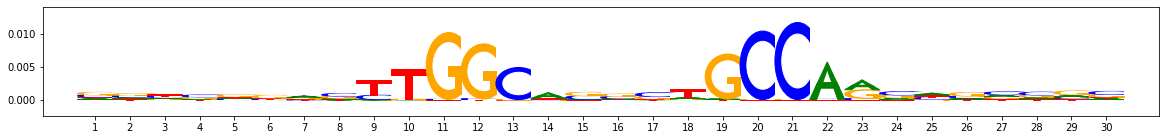

NA18983_hg38_pattern_27 368
0


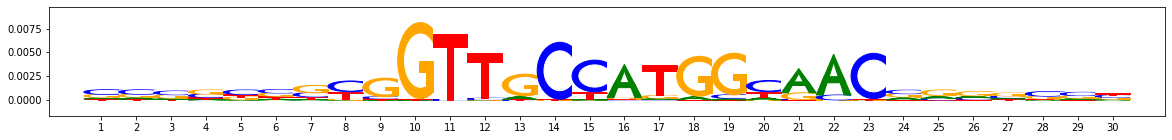

NA18983_hg38_pattern_28 280
0


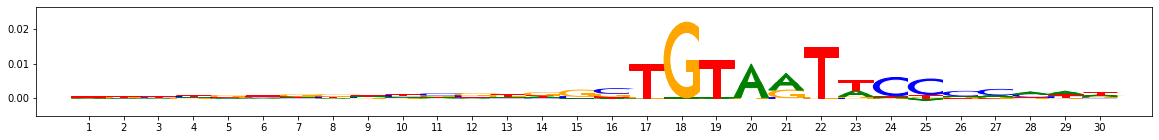

NA18983_hg38_pattern_29 232
0


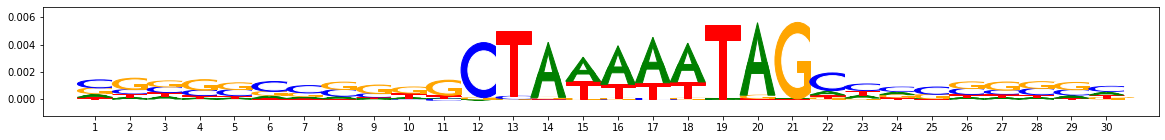

NA18983_hg38_pattern_3 8854
0


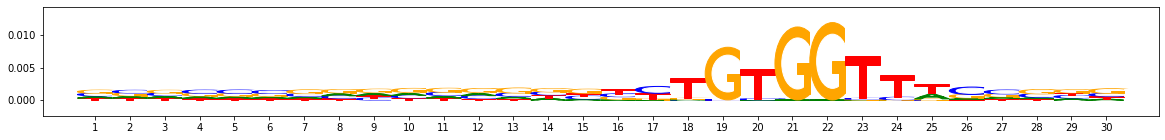

NA18983_hg38_pattern_30 220
3


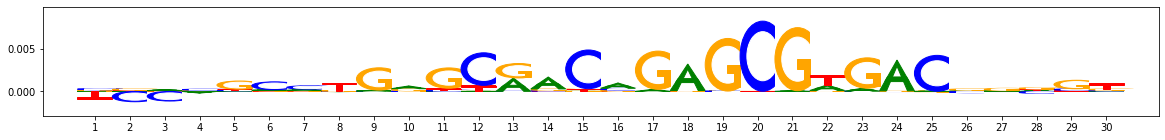

NA18983_hg38_pattern_31 172
0


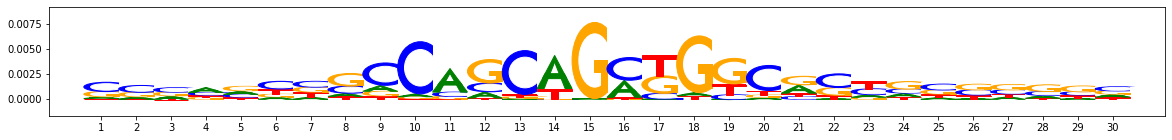

NA18983_hg38_pattern_32 170
0


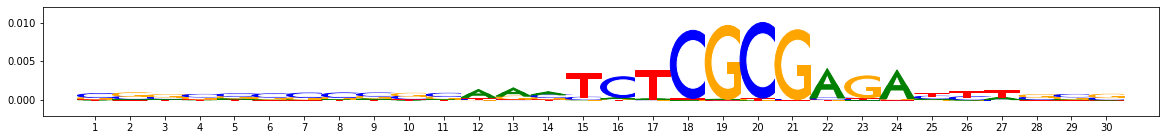

NA18983_hg38_pattern_33 168
0


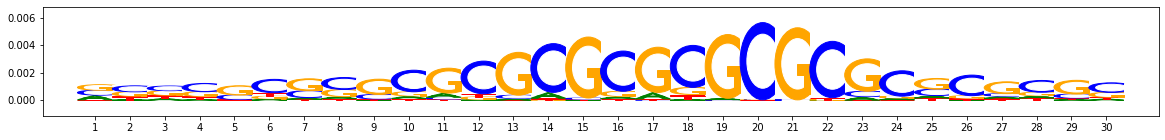

NA18983_hg38_pattern_34 166
0


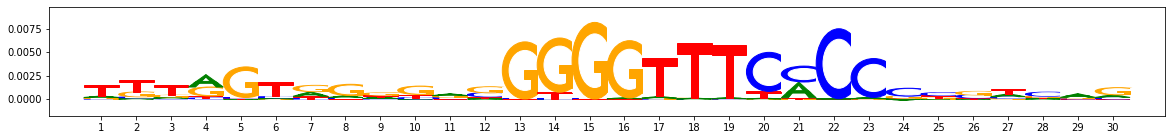

NA18983_hg38_pattern_35 158
0


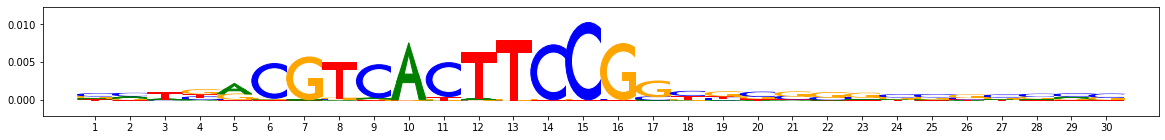

NA18983_hg38_pattern_36 128
0


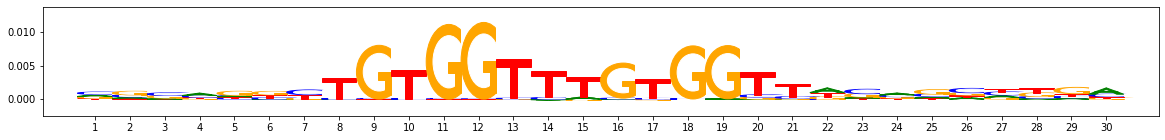

NA18983_hg38_pattern_37 100
0


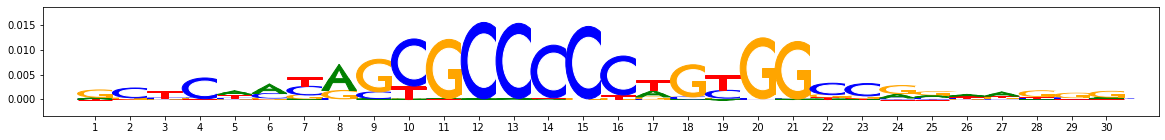

NA18983_hg38_pattern_38 100
0


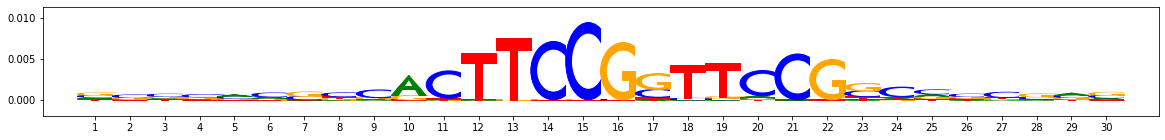

NA18983_hg38_pattern_39 72
7


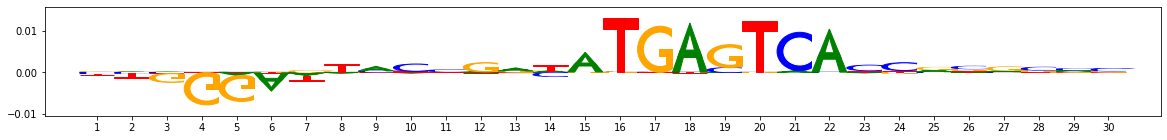

NA18983_hg38_pattern_4 8090
0


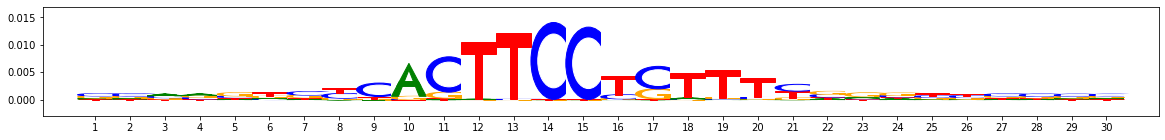

NA18983_hg38_pattern_40 71
0


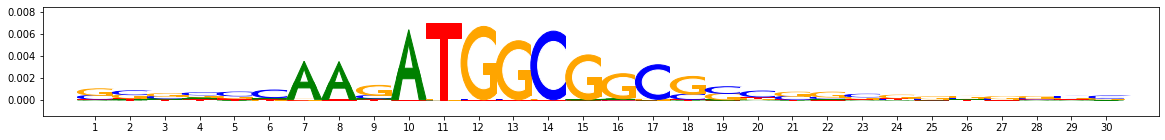

NA18983_hg38_pattern_41 69
0


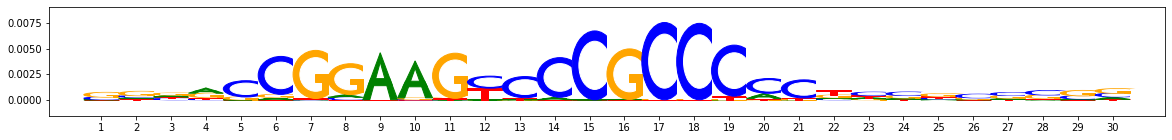

NA18983_hg38_pattern_42 64
0


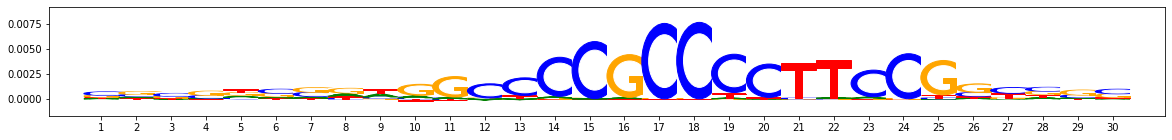

NA18983_hg38_pattern_43 60
0


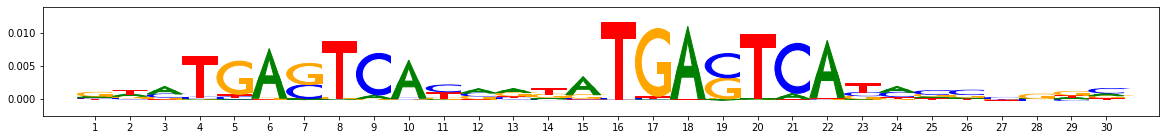

NA18983_hg38_pattern_44 56
0


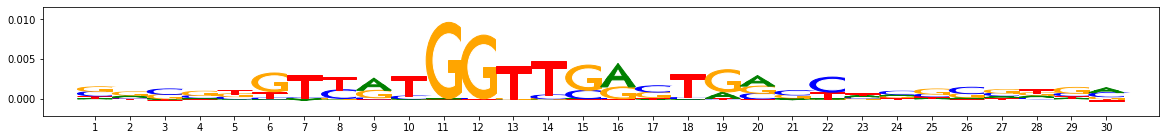

NA18983_hg38_pattern_45 55
4


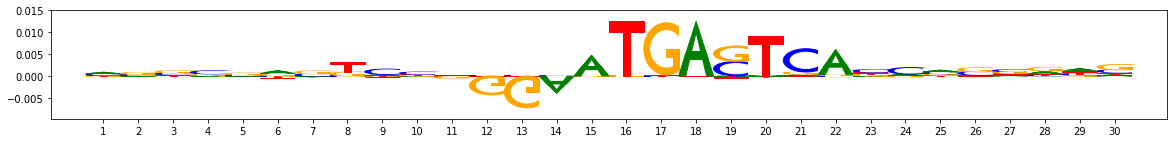

NA18983_hg38_pattern_46 44
0


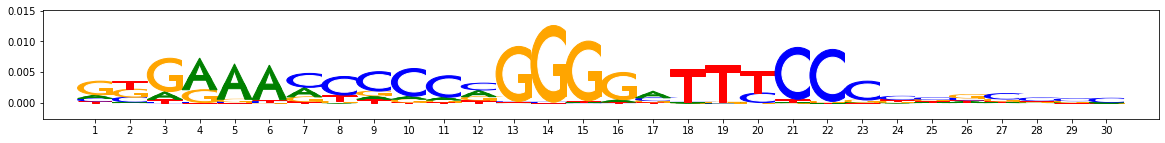

NA18983_hg38_pattern_47 44
0


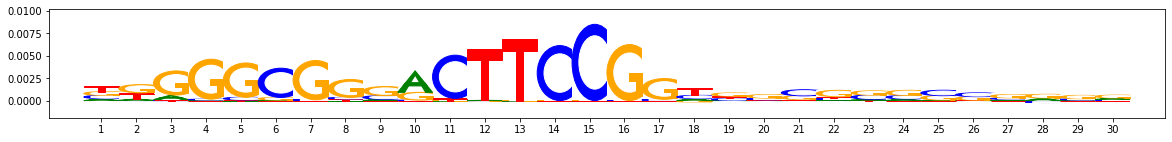

NA18983_hg38_pattern_48 41
0


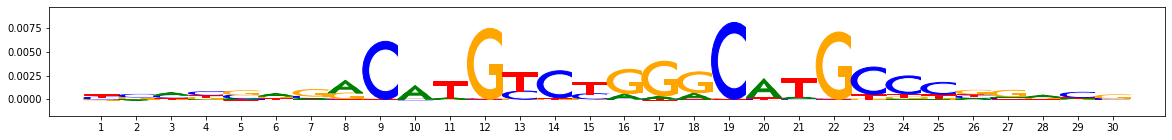

NA18983_hg38_pattern_49 35
7


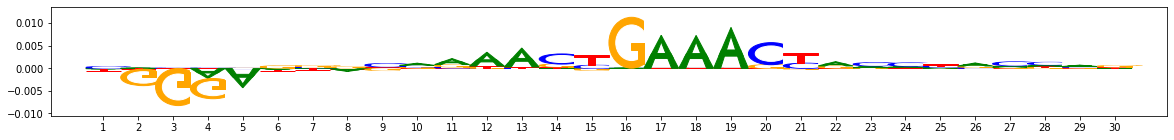

NA18983_hg38_pattern_5 7138
0


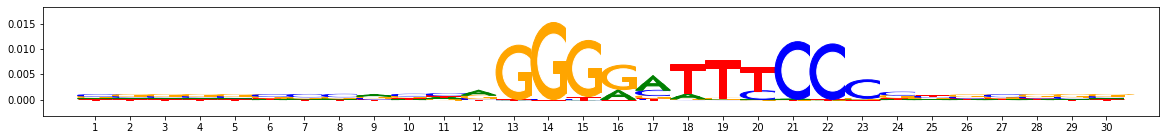

NA18983_hg38_pattern_50 33
0


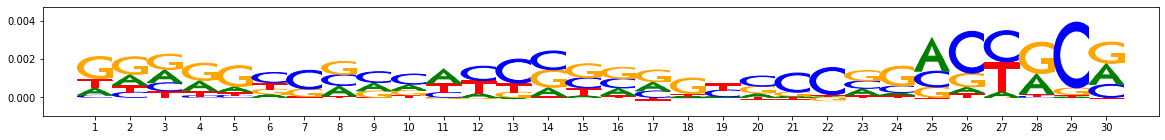

NA18983_hg38_pattern_51 23
0


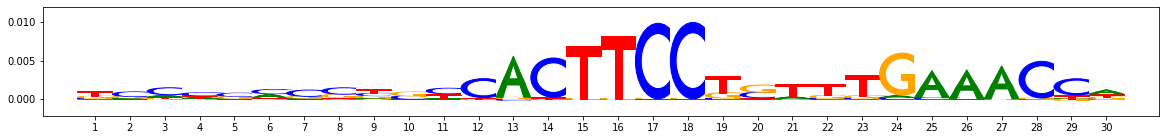

NA18983_hg38_pattern_52 23
0


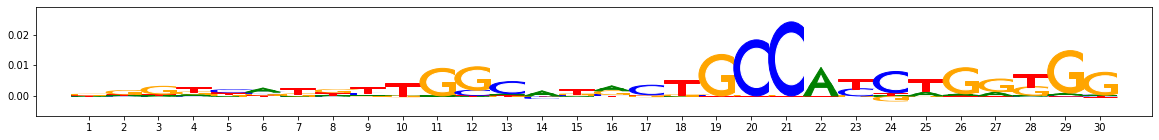

NA18983_hg38_pattern_6 5619
0


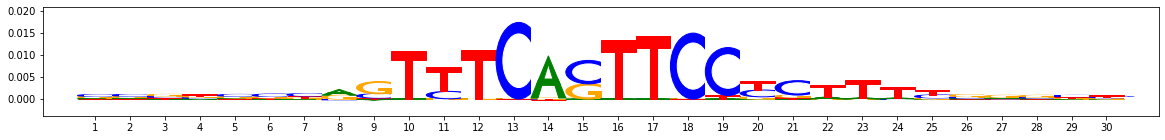

NA18983_hg38_pattern_7 3665
0


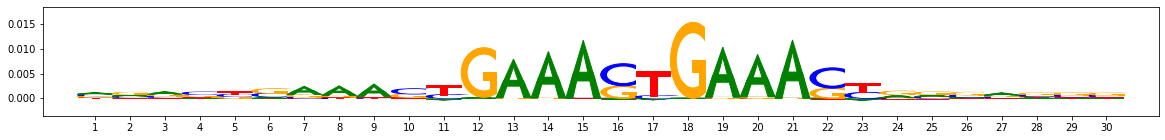

NA18983_hg38_pattern_8 2646
0


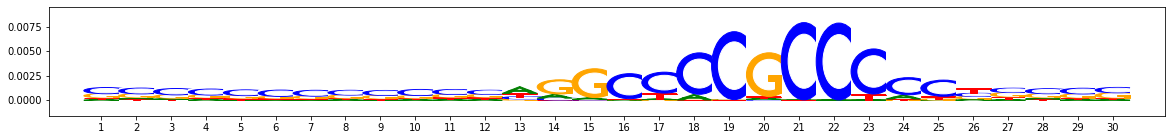

NA18983_hg38_pattern_9 2381
0


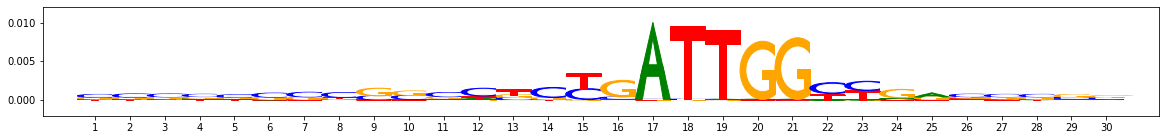

In [21]:
for sample in ['NA18983']:
    fh = h5.File(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco/{sample}_hg38.modisco_results.h5')
    patterns = list(fh['pos_patterns'])
    for pattern in patterns:
        print(sample + '_hg38_' + pattern, list(fh['pos_patterns'][pattern]['seqlets']['n_seqlets'])[0])
        print(len([x for x in np.sum(list(fh['pos_patterns'][pattern]['contrib_scores']), axis = 1) if x<0]))
        vizsequence.plot_weights(fh['pos_patterns'][pattern]['contrib_scores'])
    fh.close()

In [13]:
repetitive_motifs = ['NA12878_pattern_26', 'NA18983_pattern_33', 'HG01241_pattern_28', 'HG01241_pattern_30',
                     'HG02601_pattern_16', 'HG02601_pattern_24', 'HG02601_pattern_29', 'HG03464_pattern_34']

NA12878_hg38_pattern_26 228
0


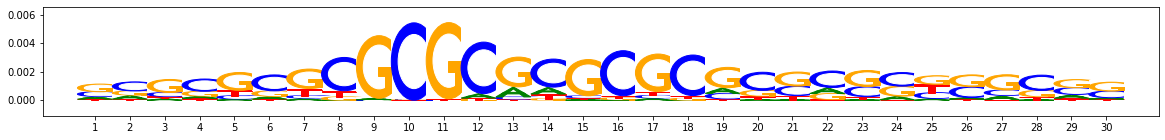

NA18983_hg38_pattern_33 168
0


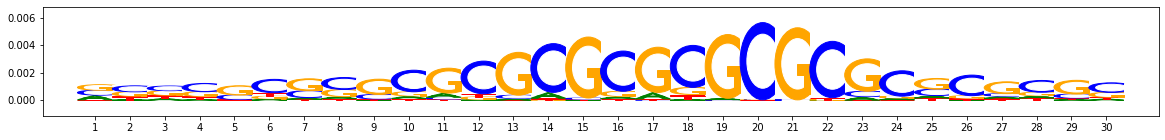

HG01241_hg38_pattern_28 269
0


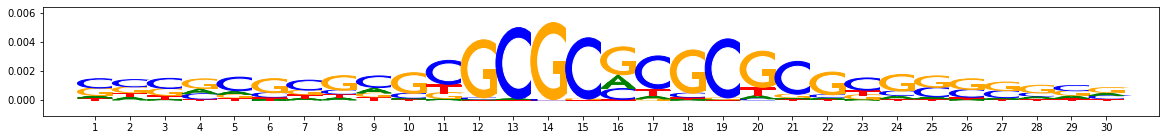

HG01241_hg38_pattern_30 174
0


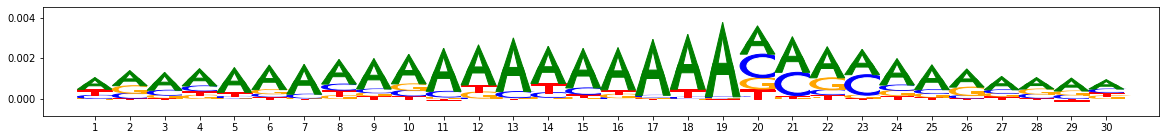

HG02601_hg38_pattern_16 928
0


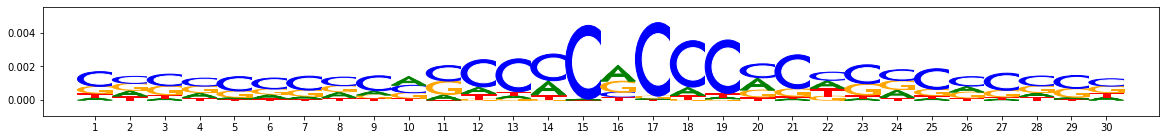

HG02601_hg38_pattern_24 340
0


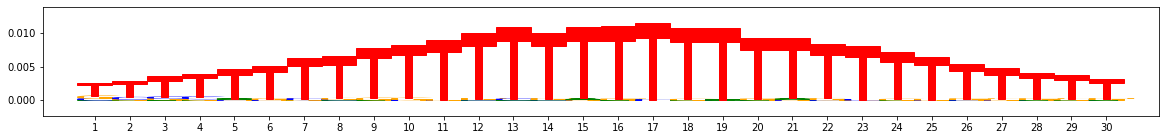

HG02601_hg38_pattern_29 277
0


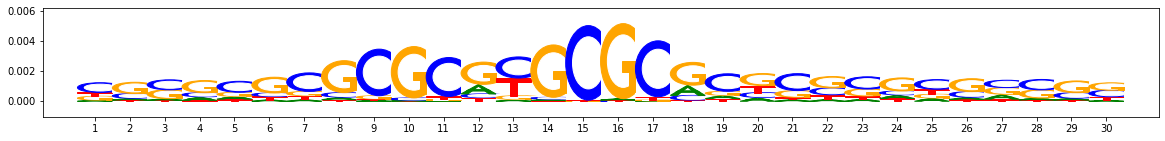

HG03464_hg38_pattern_34 116
0


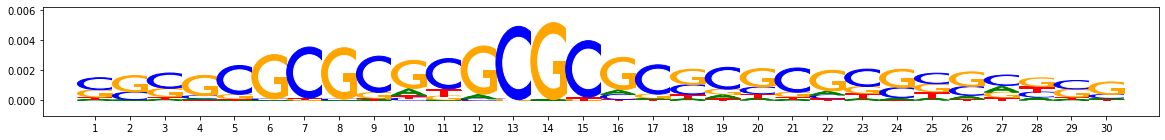

In [23]:
for pattern in repetitive_motifs:
    plot_pattern(pattern)

## Cluster motifs

In [14]:
def get_cluster_renumbering(motif_annot_df, clusters):
    seqlets_per_cluster = []
    for cluster in clusters:
        seqlets_per_cluster.append(sum(motif_annot_df[motif_annot_df['cluster'] == cluster]['num_seqlets']))

    seqlets_per_cluster = pd.DataFrame([clusters, seqlets_per_cluster]).transpose()
    seqlets_per_cluster = seqlets_per_cluster.drop_duplicates().sort_values([1], ascending = False)
    seqlets_per_cluster[2] = np.arange(len(seqlets_per_cluster))+1
    seqlets_per_cluster

    clusters_renumber = dict(zip(seqlets_per_cluster[0], seqlets_per_cluster[2]))
    return(clusters_renumber)

In [15]:
tomtom_df = pd.read_table('/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/all_samples_hg38.tomtom.txt', 
                          skipfooter = 3, engine = 'python').rename(columns = {'#Query ID': 'Query ID'})
tomtom_df = tomtom_df[~tomtom_df['Query ID'].isin(repetitive_motifs)]
tomtom_df = tomtom_df[~tomtom_df['Target ID'].isin(repetitive_motifs)]

sim = tomtom_df.pivot_table(index = 'Query ID', columns = 'Target ID', values = 'E-value', fill_value = np.nan)
x = sim.values
w = np.triu(x) +  np.triu(x, 1).T
v = np.tril(x) + np.tril(x, -1).T

sim.iloc[:,:] = np.nanmin(np.dstack([w, v]), axis=2)
sim.fillna(100, inplace=True)
sim = -np.log10(sim)
sim[np.isinf(sim)] = 10
sim

Target ID           HG01241_pattern_0  HG01241_pattern_1  HG01241_pattern_10  \
Query ID                                                                       
HG01241_pattern_0           23.239137          -2.000000           -2.000000   
HG01241_pattern_1           -2.000000          16.408273           -0.972876   
HG01241_pattern_10          -2.000000          -0.972876           17.464987   
HG01241_pattern_11          -2.000000          -2.000000           -2.000000   
HG01241_pattern_12          -2.000000          -2.000000           -2.000000   
...                               ...                ...                 ...   
NA18983_pattern_52          -0.388032          -2.000000           -2.000000   
NA18983_pattern_6           -2.000000           1.440517           -2.000000   
NA18983_pattern_7           -2.000000           3.699957           -2.000000   
NA18983_pattern_8           -0.695210          -2.000000           -2.000000   
NA18983_pattern_9           -2.000000          -2.000000           -2.000000   

Target ID           HG01241_pattern_11  HG01241_pattern_12  \
Query ID                                                     
HG01241_pattern_0            -2.000000           -2.000000   
HG01241_pattern_1            -2.000000           -2.000000   
HG01241_pattern_10           -2.000000           -2.000000   
HG01241_pattern_11           23.761194           -2.000000   
HG01241_pattern_12           -2.000000           29.009976   
...                                ...                 ...   
NA18983_pattern_52           -2.000000           -2.000000   
NA18983_pattern_6            -2.000000           -2.000000   
NA18983_pattern_7            -2.000000           -2.000000   
NA18983_pattern_8            -2.000000           -2.000000   
NA18983_pattern_9            -2.000000           -2.000000   

Target ID           HG01241_pattern_13  HG01241_pattern_14  \
Query ID                                                     
HG01241_pattern_0            -2.000000                -2.0   
HG01241_pattern_1            -2.000000                -2.0   
HG01241_pattern_10           -2.000000                -2.0   
HG01241_pattern_11           -2.000000                -2.0   
HG01241_pattern_12           -0.083993                -2.0   
...                                ...                 ...   
NA18983_pattern_52           -2.000000                -2.0   
NA18983_pattern_6            -2.000000                -2.0   
NA18983_pattern_7            -2.000000                -2.0   
NA18983_pattern_8            -2.000000                -2.0   
NA18983_pattern_9            -2.000000                -2.0   

Target ID           HG01241_pattern_15  HG01241_pattern_16  \
Query ID                                                     
HG01241_pattern_0            -2.000000           -2.000000   
HG01241_pattern_1             1.026910           -2.000000   
HG01241_pattern_10           -2.000000           -2.000000   
HG01241_pattern_11           -2.000000           -2.000000   
HG01241_pattern_12           -2.000000           -2.000000   
...                                ...                 ...   
NA18983_pattern_52           -2.000000           -0.832760   
NA18983_pattern_6            -0.099587            0.391383   
NA18983_pattern_7             1.845229           -2.000000   
NA18983_pattern_8            -2.000000           -2.000000   
NA18983_pattern_9            -2.000000           -2.000000   

Target ID           HG01241_pattern_17  ...  NA18983_pattern_48  \
Query ID                                ...                       
HG01241_pattern_0                 -2.0  ...                -2.0   
HG01241_pattern_1                 -2.0  ...                -2.0   
HG01241_pattern_10                -2.0  ...                -2.0   
HG01241_pattern_11                -2.0  ...                -2.0   
HG01241_pattern_12                -2.0  ...                -2.0   
...                                ...  ...                 ...   
NA

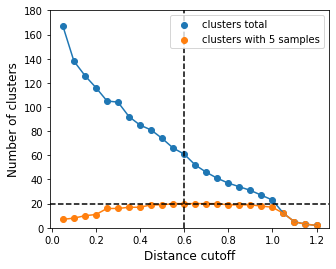

In [16]:
Z = linkage(sim, method = 'complete', metric = 'correlation')
clustering_threshold = 0.6

n_clusters, n_clusters_all_samples = [], []
for cutoff in np.arange(0.05, 1.25, 0.05):
    cl = fcluster(Z, cutoff, criterion='distance')
    o = dendrogram(Z, no_plot=True)['leaves']
    n_clusters.append(max(cl))
    
    motif_annot_df = pd.DataFrame({'motif_id':sim.index, 'cluster':cl})
    samples_per_cluster = []
    for cluster in np.unique(motif_annot_df['cluster'].values):
        samples_per_cluster.append(len(np.unique(['_'.join(x.split('_')[:2]) for x in motif_annot_df[motif_annot_df['cluster'] == cluster]['motif_id']])))
    n_clusters_all_samples.append(len([x for x in samples_per_cluster if x == 5]))
    
plt.figure(figsize = (5, 4))
plt.plot(np.arange(0.05, 1.25, 0.05), n_clusters)
plt.scatter(np.arange(0.05, 1.25, 0.05), n_clusters, label = 'clusters total')
plt.plot(np.arange(0.05, 1.25, 0.05), n_clusters_all_samples)
plt.scatter(np.arange(0.05, 1.25, 0.05), n_clusters_all_samples, label = 'clusters with 5 samples')
plt.axhline(20, ls = '--', color = 'k')
plt.axvline(clustering_threshold, ls = '--', color = 'k')
plt.xlabel('Distance cutoff', fontsize = 12)
plt.ylabel('Number of clusters', fontsize = 12)
plt.legend()
plt.ylim(0, 180)
plt.show()

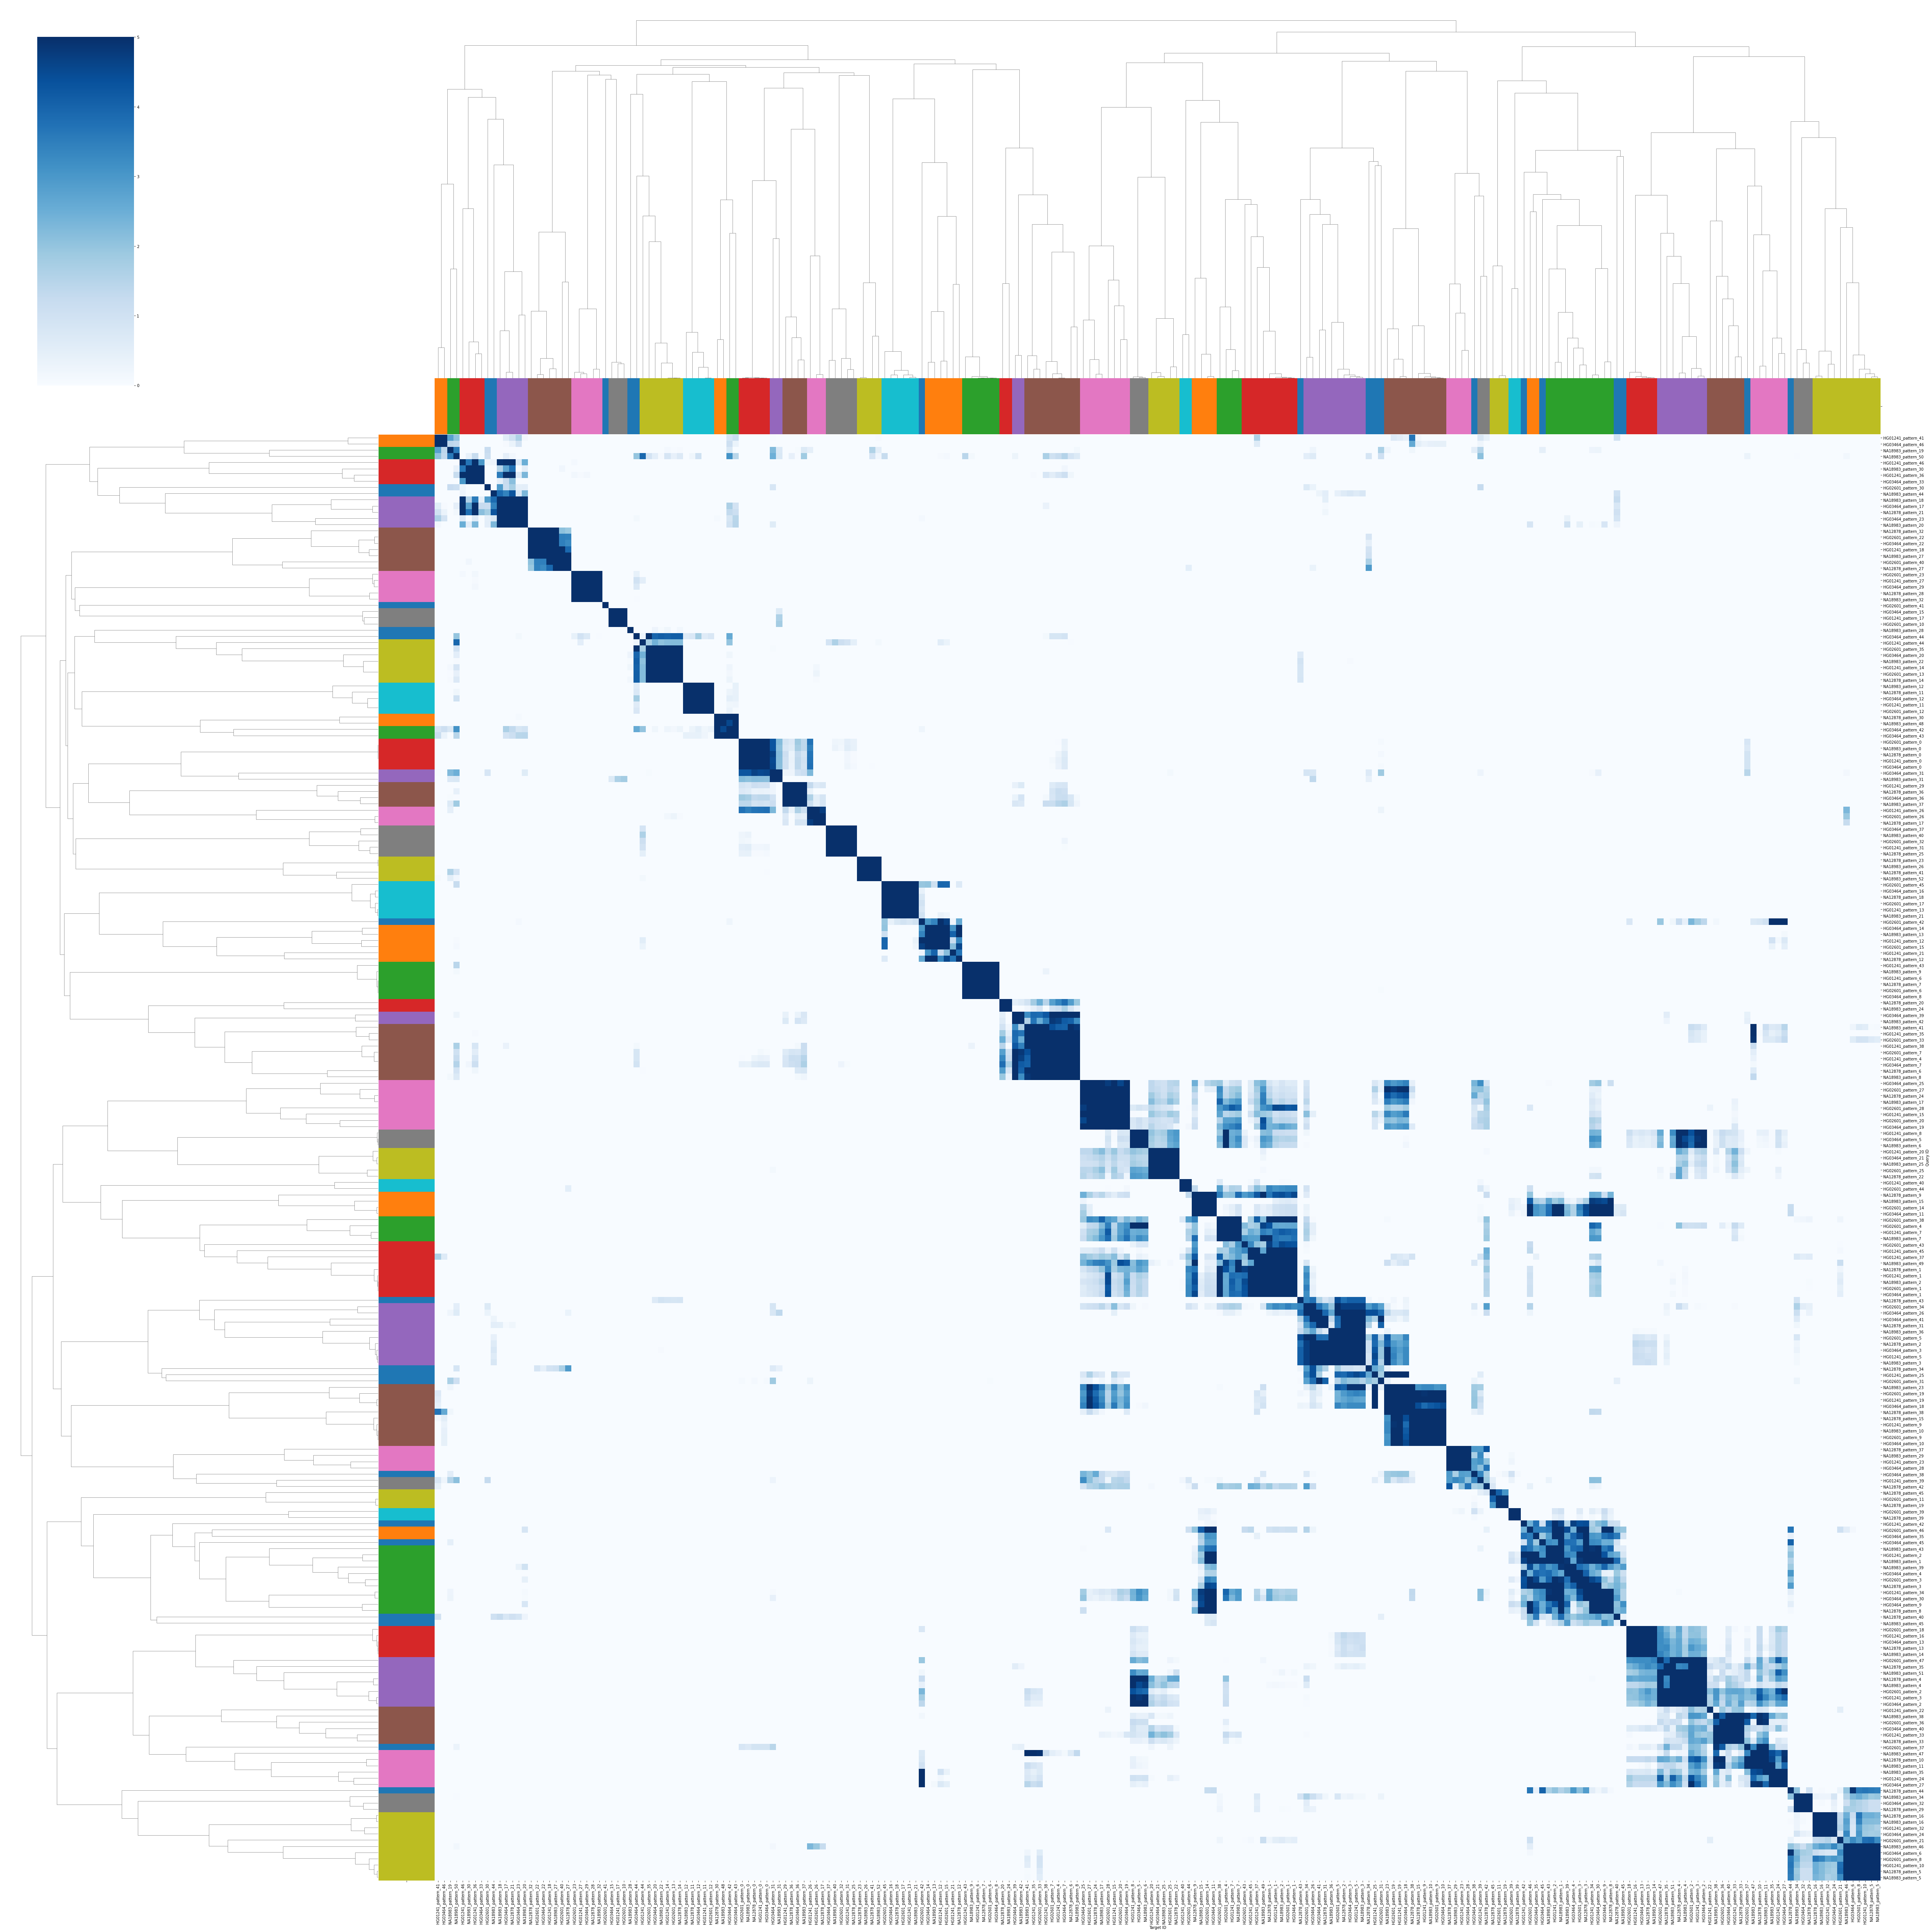

In [29]:
Z = linkage(sim, method = 'complete', metric = 'correlation')
colors_heatmap = dendrogram(Z, color_threshold = clustering_threshold, no_plot = True)['leaves_color_list']

g = sns.clustermap(sim.iloc[o,o], method = 'complete', metric = 'correlation', figsize = (70, 70), 
               row_cluster = True, col_cluster = True, cmap = 'Blues', vmin = 0, vmax = 5,
               row_colors = pd.Series(colors_heatmap, index = sim.iloc[o,o].index), 
               col_colors = pd.Series(colors_heatmap, index = sim.iloc[o,o].index))
g.savefig('/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/clusters_heatmap.pdf', bbox_inches = 'tight')

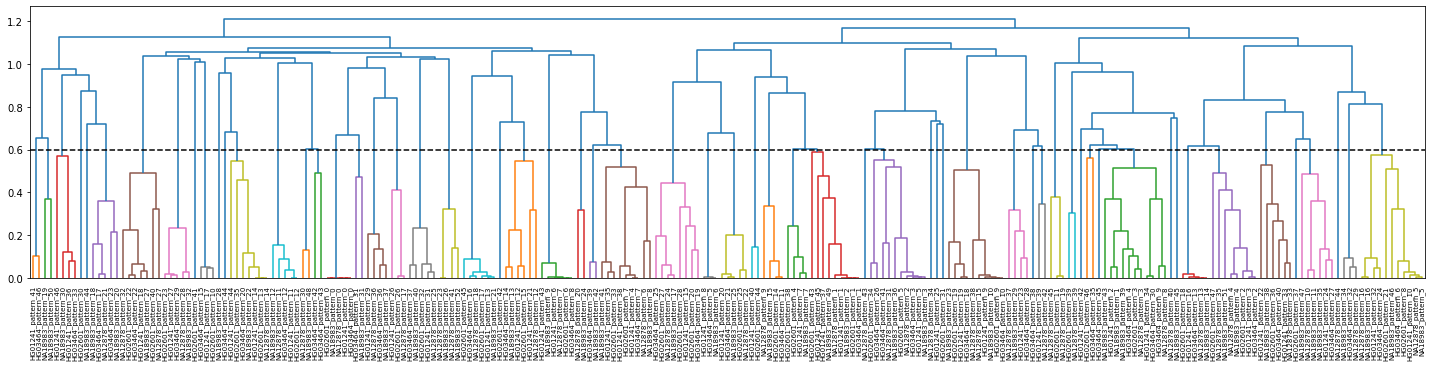

In [32]:
Z = linkage(sim, method = 'complete', metric = 'correlation')

plt.figure(figsize = (25, 5))
dendrogram(Z, color_threshold = clustering_threshold, labels = sim.index)
plt.axhline(clustering_threshold, color = 'k', ls = '--')
plt.xticks(fontsize = 7)
plt.savefig('/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/clusters_dendrogram.pdf', bbox_inches = 'tight')
plt.show()

In [33]:
# perform clustering
Z = linkage(sim, method = 'complete', metric = 'correlation')

# apply distance threshold
cl = fcluster(Z, clustering_threshold, criterion='distance')
o = dendrogram(Z, no_plot = True)['leaves']
print(f'Number of motif clusters: {max(cl)}')

motif_annot_df = pd.DataFrame({'motif_id': sim.index, 'cluster': cl})

# samples per cluster
samples_per_cluster = []
for cluster in cl:
    samples_per_cluster.append(len(np.unique(['_'.join(x.split('_')[:2]) for x in motif_annot_df[motif_annot_df['cluster'] == cluster]['motif_id']])))
motif_annot_df['samples'] = samples_per_cluster

# merge with motif information
motif_annot_df = motif_annot_df.merge(modisco_motifs_data, on = 'motif_id')

# renumber clusters by size
cluster_renumber_by_size = get_cluster_renumbering(motif_annot_df, cl)
motif_annot_df['cluster'] = [cluster_renumber_by_size[x] for x in motif_annot_df['cluster']]
motif_annot_df.sort_values(['cluster', 'samples'], ascending = True).head(20)

Number of motif clusters: 61


motif_id  cluster  samples   sample  num_seqlets best_cluster  \
0     HG01241_pattern_0        1        5  HG01241        15537  cluster_017   
45    HG02601_pattern_0        1        5  HG02601        15421  cluster_017   
90    HG03464_pattern_0        1        5  HG03464        16603  cluster_017   
136   NA12878_pattern_0        1        5  NA12878        16242  cluster_017   
181   NA18983_pattern_0        1        5  NA18983        17283  cluster_017   
1     HG01241_pattern_1        2        5  HG01241        12103          NaN   
29   HG01241_pattern_37        2        5  HG01241           44          NaN   
38   HG01241_pattern_45        2        5  HG01241           20          NaN   
46    HG02601_pattern_1        2        5  HG02601        12549          NaN   
80   HG02601_pattern_43        2        5  HG02601           37          NaN   
91    HG03464_pattern_1        2        5  HG03464        14291          NaN   
137   NA12878_pattern_1        2        5  NA12878        11647  cluster_041   
193   NA18983_pattern_2        2        5  NA18983        13686  cluster_041   
224  NA18983_pattern_49        2        5  NA18983           35  cluster_041   
12    HG01241_pattern_2        3        5  HG01241         7968  cluster_001   
26   HG01241_pattern_34        3        5  HG01241          148  cluster_001   
65    HG02601_pattern_3        3        5  HG02601         7448  cluster_001   
114  HG03464_pattern_30        3        5  HG03464          173  cluster_001   
123   HG03464_pattern_4        3        5  HG03464         5104  cluster_001   
135   HG03464_pattern_9        3        5  HG03464         1840          NaN   

       match0        motif0     cluster0         qval0  ...     cluster2  \
0    MA0139.2          CTCF  cluster_017  2.633110e-14  ...  cluster_128   
45   MA0139.2          CTCF  cluster_017  8.039100e-14  ...  cluster_128   
90   MA0139.2          CTCF  cluster_017  2.686590e-15  ...  cluster_128   
136  MA0139.2          CTCF  cluster_017  1.438000e-13  ...  cluster_128   
181  MA0139.2          CTCF  cluster_017  3.983080e-13  ...  cluster_128   
1         NaN           NaN          NaN           NaN  ...          NaN   
29        NaN           NaN          NaN           NaN  ...          NaN   
38        NaN           NaN          NaN           NaN  ...          NaN   
46        NaN           NaN          NaN           NaN  ...          NaN   
80        NaN           NaN          NaN           NaN  ...          NaN   
91        NaN           NaN          NaN           NaN  ...          NaN   
137  MA0517.2  STAT1::STAT2  cluster_041  2.022960e-02  ...  cluster_041   
193  MA0517.2  STAT1::STAT2  cluster_041  1.595770e-02  ...  cluster_041   
224  MA0653.1          IRF9  cluster_041  1.034140e-02  ...  cluster_041   
12   MA0490.3          JUNB  cluster_001  1.263590e-03  ...  cluster_001   
26   MA1142.2   FOSL1::JUND  cluster_001  1.746130e-03  ...  cluster_001   
65   MA0835.3         BATF3  cluster_001  1.120880e-03  ...  cluster_001   
114  MA1142.2   FOSL1::JUND  cluster_001  2.365750e-03  ...  cluster_001   
123  MA0490.3          JUNB  cluster_001  1.809760e-04  ...  cluster_001   
135       NaN           NaN          NaN           NaN  ...          NaN   

            qval2    match3     motif3     cluster3     qval3    match4  \
0    2.375930e-12  MA1102.3      CTCFL  cluster_017  0.028049       NaN   
45   4.303650e-12  MA1102.3      CTCFL  cluster_017  0.031083       NaN   
90   2.422250e-12  MA1102.3      CTCFL  cluster_017  0.028507       NaN   
136  1.813630e-12  MA1102.3      CTCFL  cluster_017  0.031351       NaN   
181  9.293860e-13  MA1102.3      CTCFL  cluster_017  0.039364       NaN   
1             NaN       NaN        NaN          NaN       NaN       NaN   
29            NaN       NaN        NaN          NaN       NaN       NaN   
38            NaN       NaN        NaN          NaN       NaN       NaN   
46            NaN       NaN        NaN          NaN       NaN 

## Plot clusters

In [35]:
def extract_pwm(pwm_id):
    with open('/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/all_samples_hg38.tf_modisco.meme') as f:
        pwms = f.read()
    pwm_to_extract = pwms.split(pwm_id + ' ' + pwm_id)[-1].split('MOTIF')[0].split('\n')
    pwm_to_extract = [x.lstrip(' ').split() for x in pwm_to_extract if x != ''][1:]
    pwm_to_extract = pd.DataFrame(pwm_to_extract)
    for i in range(4):
        pwm_to_extract[i] = [float(x) for x in pwm_to_extract[i]]
    pwm_to_extract = pwm_to_extract.transpose().values
    return(pwm_to_extract)

def relative_info_content(pwm):
    p = pwm/np.sum(pwm, axis = 1)[:,np.newaxis]
    ic = 2+np.sum(p*np.nan_to_num(np.log2(p)), axis = 1)
    ric = p*ic[:,np.newaxis]
    return(ric)

def rev_compl(st):
    nn = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(nn[n] for n in reversed(st))

def abs_mean(x):
    return np.mean(np.abs(x))

def get_jaspar_consensus_cluster(alignment_df):
    jaspar_consensus_cluster = alignment_df[['num_seqlets', 'best_cluster']].groupby('best_cluster').sum()
    if len(jaspar_consensus_cluster) != 0:
        jaspar_consensus_cluster = jaspar_consensus_cluster.sort_values(['num_seqlets'], ascending = False).index[0]
    else:
        jaspar_consensus_cluster = 'not found'
    return(jaspar_consensus_cluster)

def get_jaspar_consensus_motifs(alignment_df):
    jaspar_consensus_motifs = pd.DataFrame([alignment_df[['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4']].values.flatten(),
                                            alignment_df[['motif0', 'motif1', 'motif2', 'motif3', 'motif4']].values.flatten()]).transpose()
    jaspar_consensus_motifs = jaspar_consensus_motifs[jaspar_consensus_motifs[0] == get_jaspar_consensus_cluster(alignment_df)]
    if len(jaspar_consensus_motifs[0]) != 0:
        jaspar_consensus_motifs = ', '.join(list(np.unique(jaspar_consensus_motifs[1].values)))
    else:
        jaspar_consensus_motifs = 'motifs not found'
    return(jaspar_consensus_motifs)

def process_cluster(tomtom_df, motif_annot_df, cluster):
    df = motif_annot_df.groupby('cluster').get_group(cluster)
    motifs = df['motif_id'].values

    ###
    ### PREPARE TABLE FOR MOTIF MERGING
    ###
    rows = (tomtom_df['Query ID'].isin(motifs)) & (tomtom_df['Target ID'].isin(motifs))
    all_pairwise_df = tomtom_df[rows] 
    #seed_motif = all_pairwise_df.groupby('Query ID').agg({'Overlap': abs_mean}).sort_values('Overlap', ascending=False).index[0]
    seed_motif = all_pairwise_df.groupby('Query ID').agg({'E-value': np.median}).sort_values('E-value', ascending=True).index[0]
    rows = (tomtom_df['Query ID'] == seed_motif) & (tomtom_df['Target ID'].isin(motifs))
    pairwise_df = tomtom_df[rows] 

    pivot_df = all_pairwise_df.pivot_table(index='Query ID', columns='Target ID', values='Optimal offset')
    q = pivot_df.loc[seed_motif]
    qi = q[~np.isnan(q)].index

    query = []
    target = []
    offset = []
    orientation = []
    target_consensus = []
    query_consensus = []
    
    for m in [x for x in motifs if x not in pairwise_df['Target ID'].values]:
        t = pivot_df[m]
        ti = t[~np.isnan(t)].index

        try:
            common_motif = (qi&ti)[0]
        except:
            print(f'ERROR: {m} no alignments available!')
            continue

        row_q = (all_pairwise_df['Query ID'] == seed_motif) & (all_pairwise_df['Target ID'] == common_motif)
        row_t = (all_pairwise_df['Query ID'] == common_motif) & (all_pairwise_df['Target ID'] == m)

        offset_q = all_pairwise_df[row_q]['Optimal offset'].iloc[0]
        offset_t = all_pairwise_df[row_t]['Optimal offset'].iloc[0]

        orientation_q = all_pairwise_df[row_q]['Orientation'].iloc[0]
        orientation_t = all_pairwise_df[row_t]['Orientation'].iloc[0]

        consensus_q = all_pairwise_df[row_q]['Query consensus'].iloc[0]

        consensus_tq = all_pairwise_df[row_t]['Query consensus'].iloc[0]
        consensus_tt = all_pairwise_df[row_t]['Target consensus'].iloc[0]

        offset_p = len(consensus_tt) - offset_t - len(consensus_tq)

        target.append(m)
        query_consensus.append(consensus_q)

        if orientation_t == orientation_q:
            orientation.append('+')
            target_consensus.append(consensus_tt)

            if orientation_t == '+':
                offset.append(offset_q+offset_t)
            else:
                offset.append(offset_p+offset_q)
        else:            
            orientation.append('-')
            target_consensus.append(rev_compl(consensus_tt))

            if orientation_q == '-':        
                offset.append(offset_p+offset_q)
            else:
                offset.append(offset_q+offset_t)

    z = pd.DataFrame({
            'Query ID': seed_motif,
            'Target ID': target,
            'Optimal offset': offset,
            'p-value': 0, 
            'E-value': 0,
            'q-value': 1,
            'Overlap': 0,
            'Query consensus': query_consensus,
            'Target consensus': target_consensus,
            'Orientation': orientation,
        })

    if len(z) > 0:
        pairwise_df = pd.concat([pairwise_df, z])

    ###
    ### WEIGHT-AVERAGE PWM
    ###
    w = pairwise_df['Target consensus'].str.len()
    left = min(-pairwise_df['Optimal offset'])
    l_offset = -left - pairwise_df['Optimal offset']
    right = max(l_offset + w)
    r_offset = right - w - l_offset

    alignment_df = pairwise_df.drop(['Query ID', 'Optimal offset', 'p-value', 'E-value', 'q-value', 'Overlap', 'Query consensus'], axis=1)
    alignment_df.loc[:,'w'] = w
    alignment_df.loc[:,'l_offset'] = l_offset
    alignment_df.loc[:,'r_offset'] = r_offset
    alignment_df.columns = ['motif', 'consensus', 'strand', 'w', 'l_offset', 'r_offset']

    alignment_df.reset_index(drop=True, inplace=True)

    alignment_df = alignment_df.merge(df.reset_index(), left_on='motif', right_on='motif_id')

    alignment_df.sort_values(by='motif_id', inplace=True)
    alignment_df.reset_index(inplace=True)

    n = len(alignment_df)
    l = min(alignment_df['l_offset'])
    r = max(alignment_df['r_offset'] + alignment_df['w'])
    w = r - l

    summed_pwm = np.zeros((4, w, n))
    
    for i, row in alignment_df.iterrows():

        motif_id = row['motif']
        scaling_factor = row['num_seqlets']/sum(alignment_df['num_seqlets'])
        rc = row['strand'] == '-'
        left = row['l_offset']
        width = row['w']

        pwm = extract_pwm(motif_id)

        if rc:
            pwm = pwm[::-1,::-1]

        extended_pwm = np.ones((4, int(w))) * 0.25 * scaling_factor
        extended_pwm[:,left:left+width] = pwm * scaling_factor

        summed_pwm[:,:,i] += extended_pwm

    avg_pwm = np.nansum(summed_pwm, axis=2).T

    ic = relative_info_content(avg_pwm)
    total_ic = ic.sum(axis=1)

    cdf = np.cumsum(total_ic)/np.sum(total_ic)
    s = np.where(cdf > 0.05)[0][0]
    e = np.where(cdf > 0.95)[0][0] + 1    

    avg_pwm = avg_pwm[s:e,:]
    
    ###
    ### PLOT ALL PWMS FOR CLUSTER
    ###
    fig = plt.figure()
    fig.set_size_inches((w+2)*.125+2, (n+1)*0.5+1)

    gs = mgridspec.GridSpec(n+1, 1)

    for i, row in alignment_df.sort_values('num_seqlets', ascending = False).iterrows():
            ax = fig.add_subplot(gs[i+1, :])

            motif_id = row['motif']
            rc = row['strand'] == '-'
            left = row['l_offset']
            width = row['w']

            pwm = extract_pwm(motif_id)

            if rc:
                pwm = pwm[::-1,::-1]

            sequence.seq_plot(relative_info_content(pwm.T), ax=ax, offset=left)

            ax.axvspan(l-1, s, fc='lightgrey', alpha=0.5)
            ax.axvspan(e, r+1, fc='lightgrey', alpha=0.5)

            ax.set_xlim(left=l-1, right=r+1)
            ax.set_ylim(bottom=0, top=2.1)

            ax.xaxis.set_visible(False)
            ax.set_yticks([])

            ax.set_ylabel(str(row['motif']) + '\nN_seqlets=' + str(row['num_seqlets']), rotation=0, ha='right', va='center', fontsize='medium')

    ax = fig.add_subplot(gs[0,:])

    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax, offset=s)

    ax.set_xlim(left=l-1, right=r+1)
    ax.set_ylim(bottom=0, top=2.1)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])

    ax.axvspan(s, e, fc='none', ec='r', lw=2, clip_on=False)
    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]

    ax.set_ylabel('Weight-averaged\nconsensus', rotation=0, ha='right', va='center', fontsize='large', fontweight='bold', color='r')

    figw, figh = fig.get_size_inches()
    height_frac = (figh-0.75)/figh

    gs.update(left=1-((figw-1.75)/figw), right=(figw-0.25)/figw, top=(figh-0.75)/figh, bottom=1-((figh-0.25)/figh))
    
    n_samples = len(np.unique(['_'.join(x.split('_')[:2]) for x in alignment_df['motif']]))
    n_motifs = len(alignment_df)
    jaspar_consensus_cluster = get_jaspar_consensus_cluster(alignment_df)
    jaspar_consensus_motifs = get_jaspar_consensus_motifs(alignment_df)

    fig.suptitle(f'Cluster {cluster} (samples={n_samples}, motifs={n_motifs})\nJASPAR {jaspar_consensus_cluster} ({jaspar_consensus_motifs})', 
                 fontweight='bold', fontsize='large', y=1-(.5/figh), va='center')
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/clusters/cluster_{cluster}.pdf', bbox_inches = 'tight')
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/clusters/cluster_{cluster}.png', bbox_inches = 'tight')
    plt.show()
    
    ###
    ### PLOT WEIGHT-AVERAGED CONSENSUS PWM
    ###
    w = avg_pwm.shape[0]

    fig = plt.figure()
    fig.set_size_inches(w*0.125, 0.5)

    figw, figh = fig.get_size_inches() 

    gs = mgridspec.GridSpec(1, 1)
    gs.update(left=0, right=1, top=1, bottom=0)

    ax = fig.add_subplot(gs[:,:])

    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax)

    ax.set_xlim(left=0, right=w)
    ax.set_ylim(bottom=0, top=2.1)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]

    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/logos/cluster_{cluster}.pdf', bbox_inches = 'tight')
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/logos/cluster_{cluster}.png', bbox_inches = 'tight')

    ###
    ### PLOT REVERSE COMPLEMENT WEIGHT-AVERAGED CONSENSUS PWM
    ###
    w = avg_pwm.shape[0]

    fig = plt.figure()
    fig.set_size_inches(w*0.125, 0.5)

    figw, figh = fig.get_size_inches() 

    gs = mgridspec.GridSpec(1, 1)
    gs.update(left=0, right=1, top=1, bottom=0)

    ax = fig.add_subplot(gs[:,:])

    sequence.seq_plot(relative_info_content(avg_pwm)[::-1,::-1], ax=ax)

    ax.set_xlim(left=0, right=w)
    ax.set_ylim(bottom=0, top=2.1)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]

    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/logos/cluster_{cluster}_rc.pdf', bbox_inches = 'tight')
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/logos/cluster_{cluster}_rc.png', bbox_inches = 'tight')

    ###
    ### SAVE WEIGHT-AVERAGED CONSENSUS PWM
    ###
    header_line = f'>Cluster {cluster} (samples={n_samples}, motifs={n_motifs}), JASPAR {jaspar_consensus_cluster} ({jaspar_consensus_motifs})'
    mat = pd.DataFrame(avg_pwm.T, index=['A:', 'C:', 'G:', 'T:']).to_string(header=False)

    with open(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/pwms/cluster_{cluster}.pfm', 'w') as fh:
        fh.write(header_line + '\n' + mat + '\n')

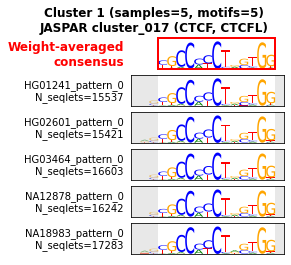

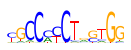

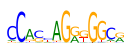

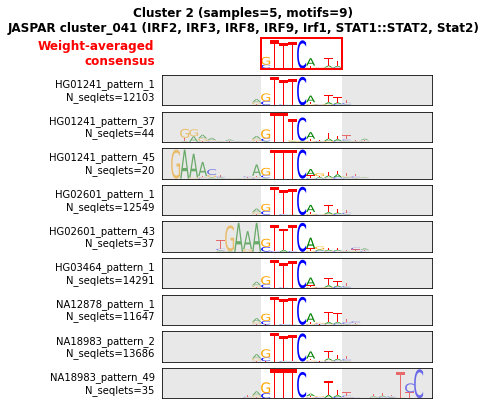

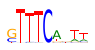

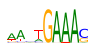

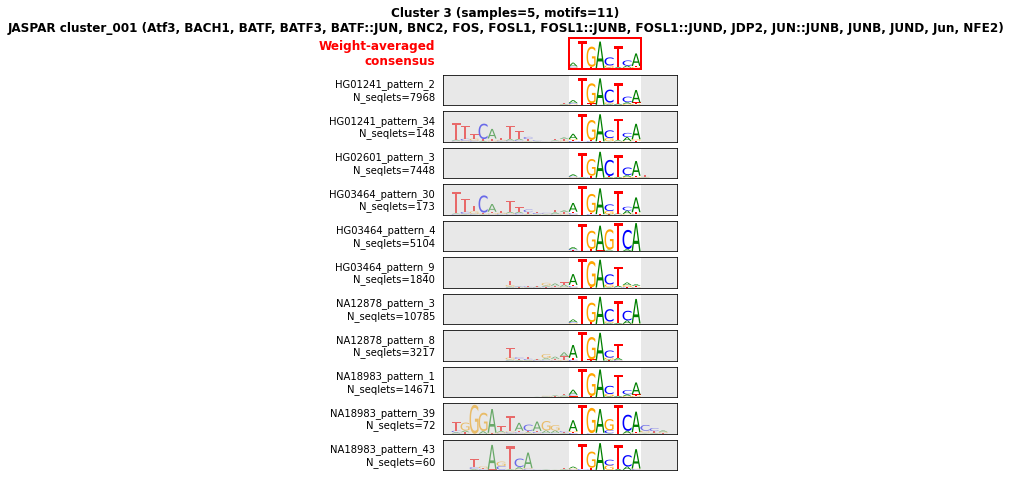

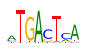

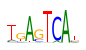

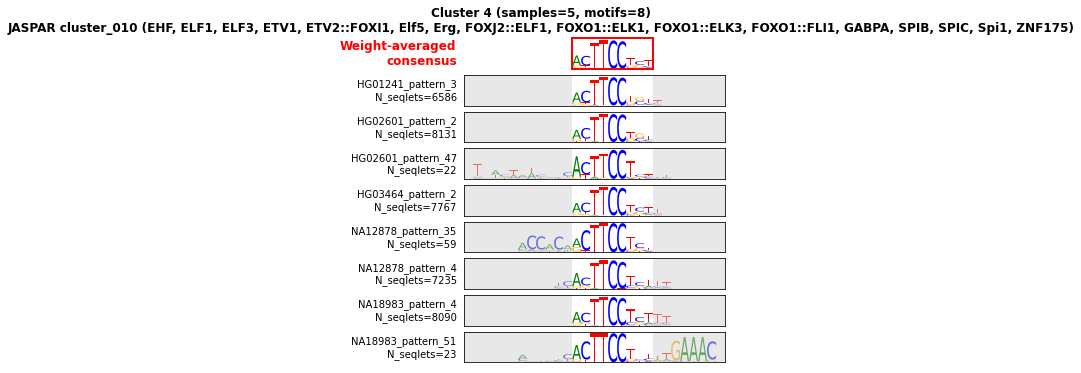

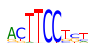

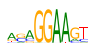

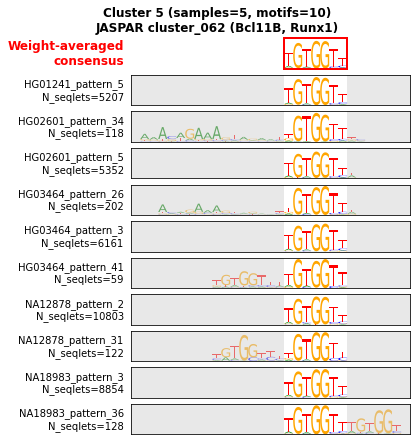

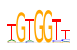

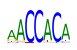

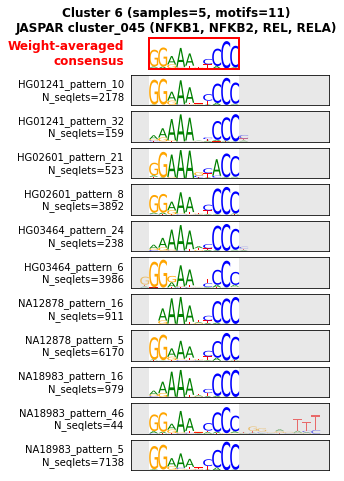

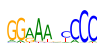

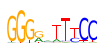

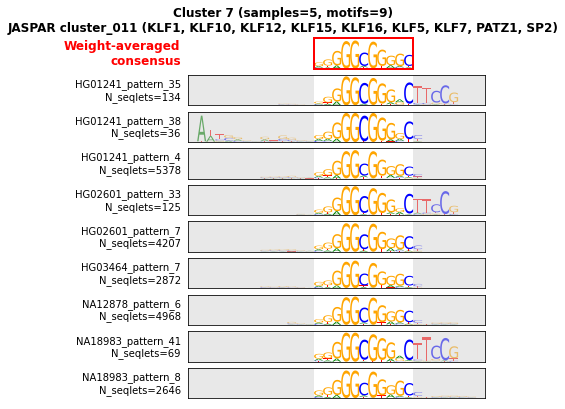

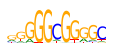

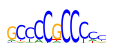

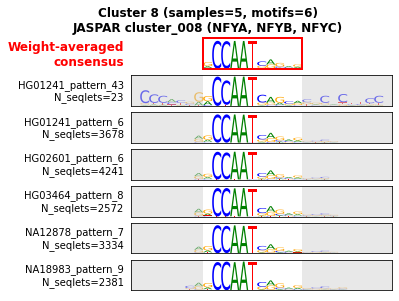

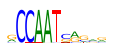

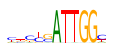

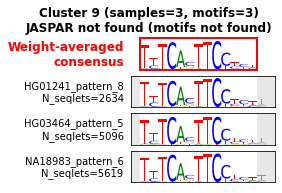

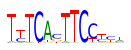

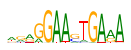

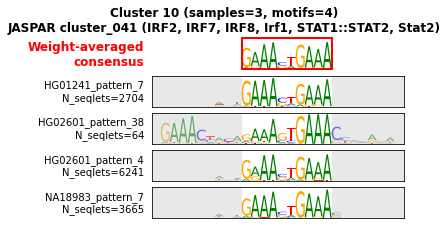

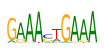

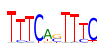

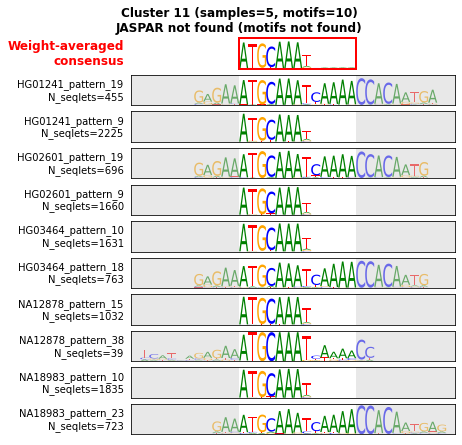

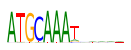

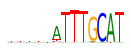

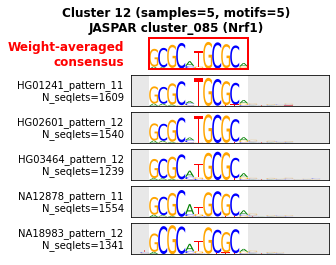

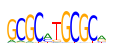

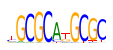

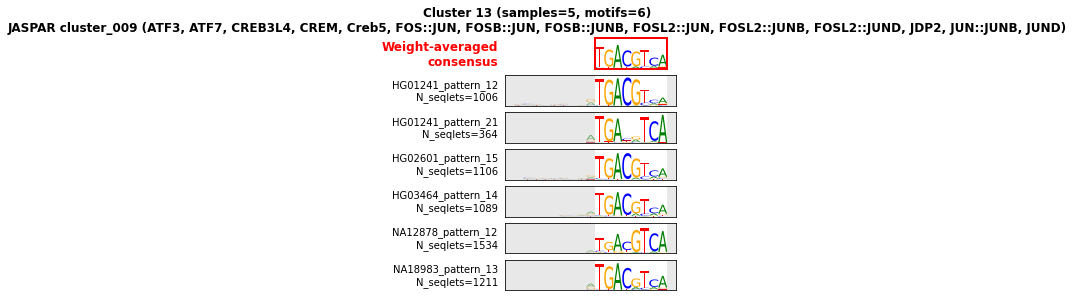

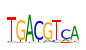

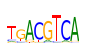

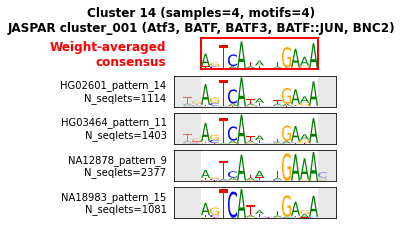

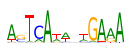

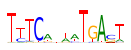

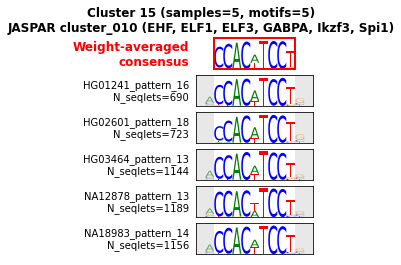

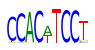

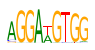

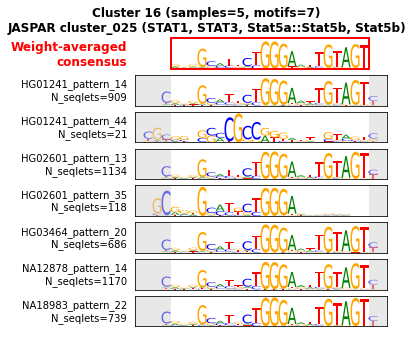

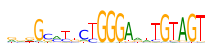

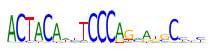

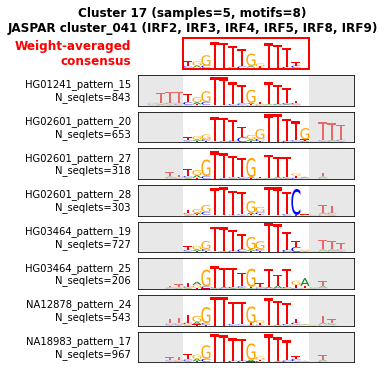

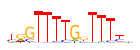

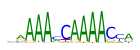

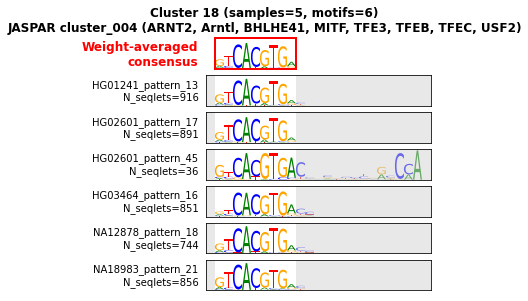

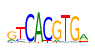

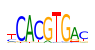

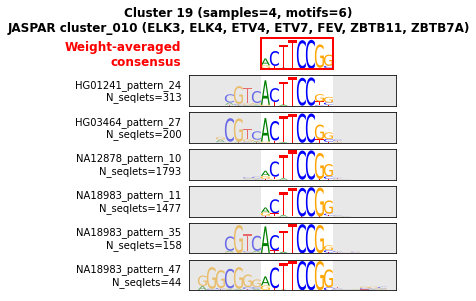

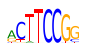

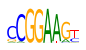

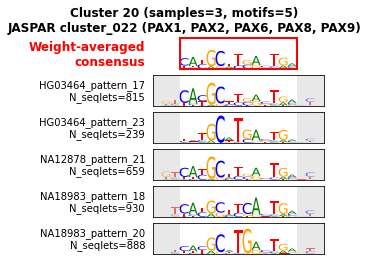

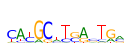

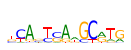

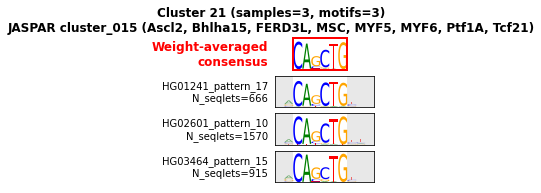

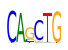

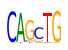

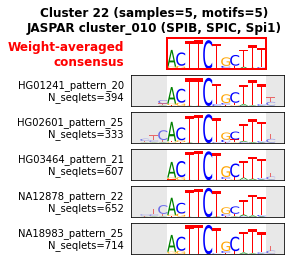

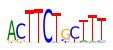

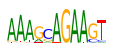

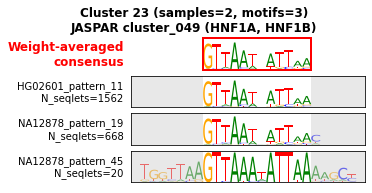

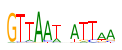

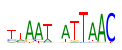

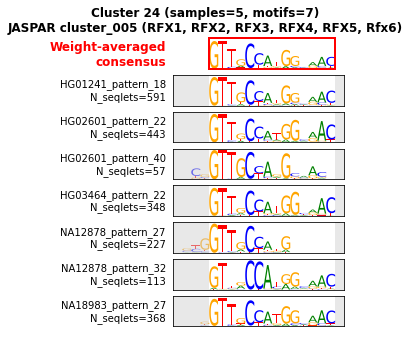

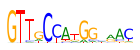

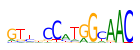

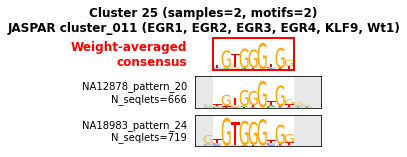

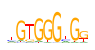

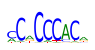

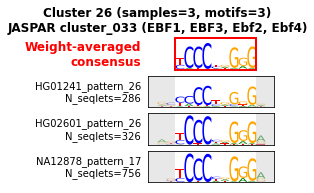

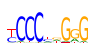

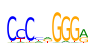

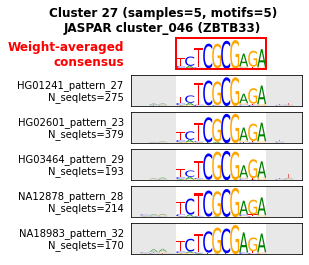

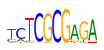

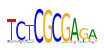

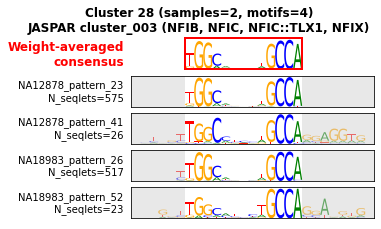

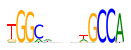

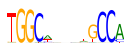

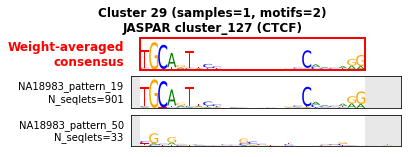

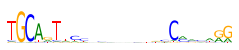

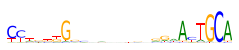

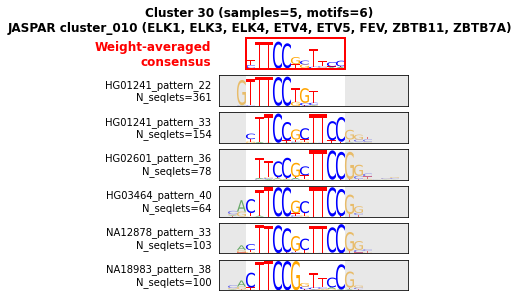

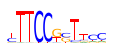

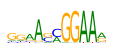

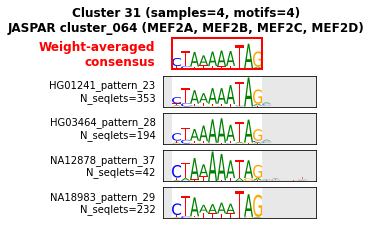

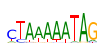

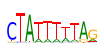

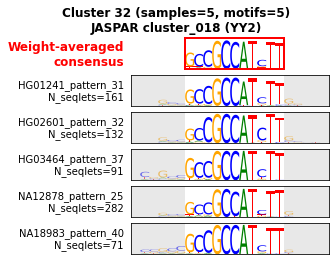

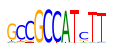

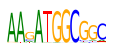

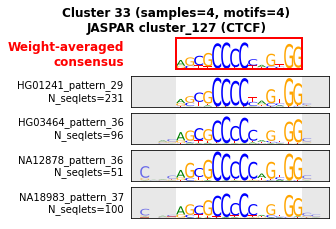

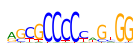

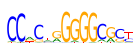

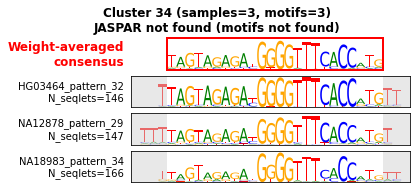

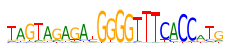

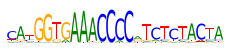

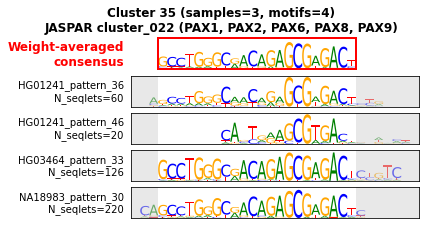

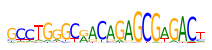

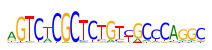

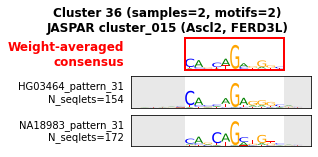

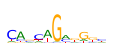

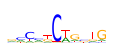

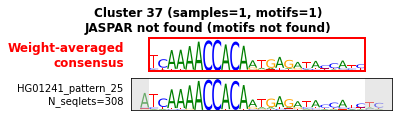

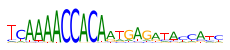

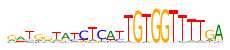

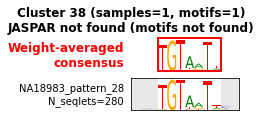

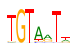

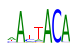

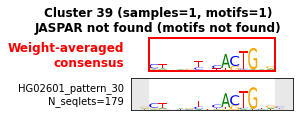

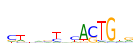

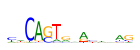

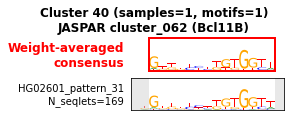

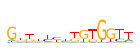

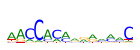

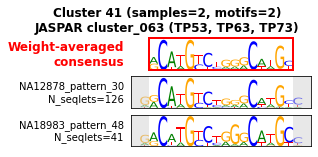

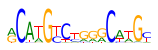

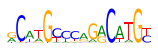

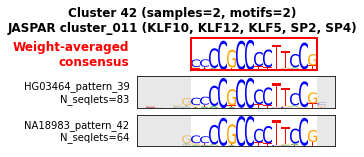

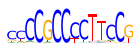

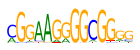

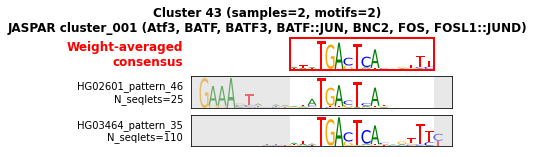

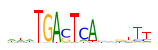

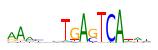

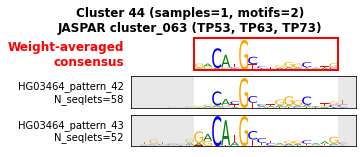

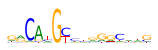

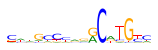

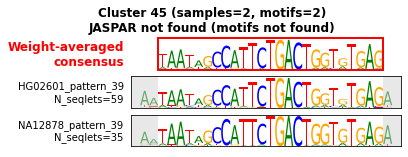

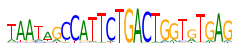

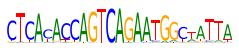

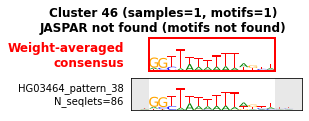

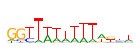

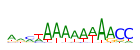

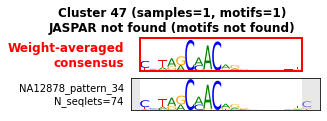

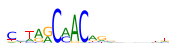

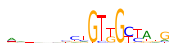

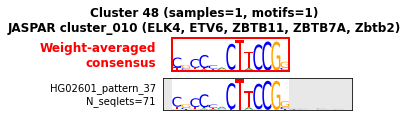

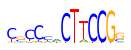

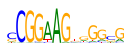

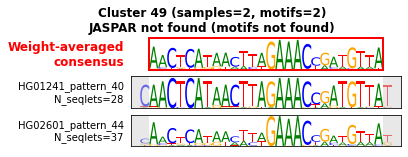

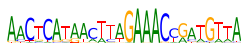

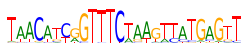

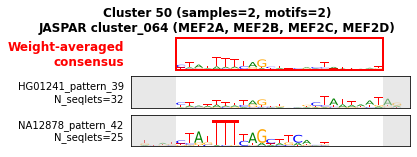

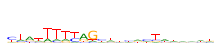

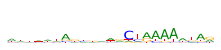

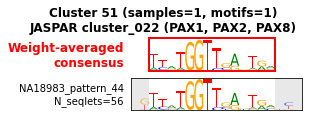

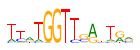

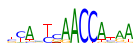

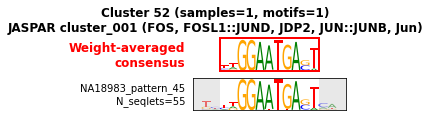

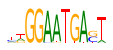

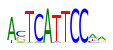

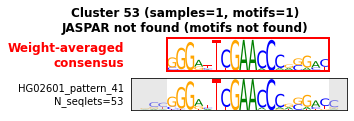

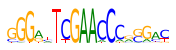

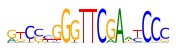

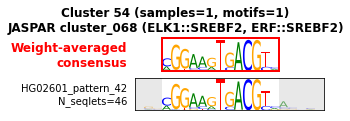

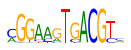

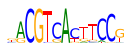

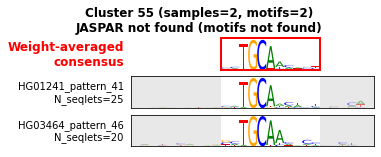

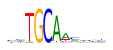

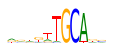

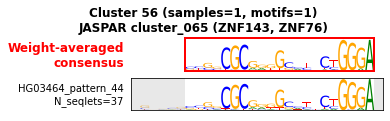

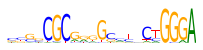

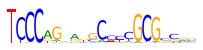

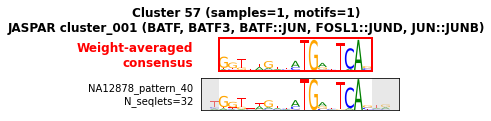

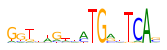

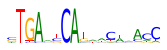

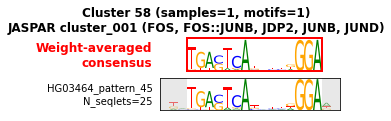

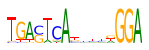

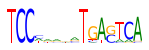

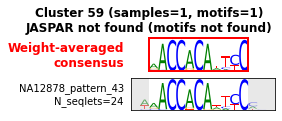

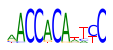

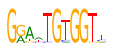

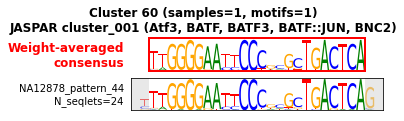

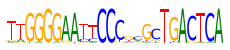

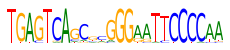

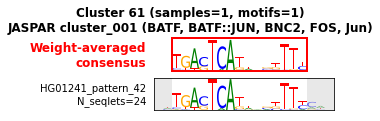

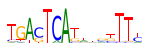

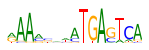

In [36]:
for i in range(1, max(cl)+1):
    process_cluster(tomtom_df, motif_annot_df, i)

## Analyse motif clusters

In [2]:
motif_clusters = pd.read_csv('/DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/annotated_motif_clusters.txt', sep = '\t')
motif_clusters['cluster_order'] = [int(x) for x in motif_clusters['cluster_order']]
motif_clusters['group_order'] = [int(x) for x in motif_clusters['group_order']]
motif_clusters = motif_clusters.sort_values('cluster_order')
motif_clusters

cluster_id  threshold  n_samples  n_motifs cluster_name  cluster_order  \
0            1        0.6          5         5         CTCF              1   
1            2        0.6          5         9        IRF_1              2   
2           10        0.6          3         4        IRF_2              3   
3           17        0.6          5         8        IRF_3              4   
4            3        0.6          5        11          AP1              5   
5            4        0.6          5         8        ETS_1              6   
6           15        0.6          5         5        ETS_2              7   
7           22        0.6          5         5        ETS_3              8   
8           30        0.6          5         6        ETS_4              9   
9           19        0.6          4         6        ETS_5             10   
10           5        0.6          5        10         RUNX             11   
11           6        0.6          5        11         NFKB             12   
12           7        0.6          5         9           SP             13   
13           8        0.6          5         6          NFY             14   
14          11        0.4          5         6          OCT             15   
15          12        0.6          5         5         NRF1             16   
16          13        0.6          5         6          CRE             17   
17          16        0.6          5         7       ZNF143             18   
18          18        0.6          5         6       EBOX_1             19   
19          21        0.6          3         3       EBOX_2             20   
20          24        0.6          5         7          RFX             21   
21          27        0.6          5         5       ZBTB33             22   
22          32        0.6          5         5          YY1             23   
23          31        0.6          4         4         MEF2             24   
24          20        0.6          3         5        PAX_1             25   
25          35        0.6          3         4        PAX_2             26   
26          26        0.6          3         3          EBF             27   
27          23        0.6          2         3         HNF1             28   
28          25        0.6          2         2         EGR1             29   
29          28        0.6          2         4          NFI             30   
30          41        0.6          2         2         TP53             31   
31          14        0.6          4         4      AP1+IRF             32   
32           9        0.6          3         3      ETS+IRF             33   
33          24        0.4          4         4     OCT+RUNX             34   

           group  group_order  
0           CTCF            1  
1            IRF            2  
2            IRF            2  
3            IRF            2  
4            AP1            3  
5            ETS            4  
6            ETS            4  
7            ETS            4  
8            ETS            4  
9            ETS            4  
10          RUNX            5  
11          NFKB            6  
12            SP            7  
13           NFY            8  
14           OCT            9  
15          NRF1           10  
16           CRE           11  
17        ZNF143           12  
18          EBOX           13  
19          EBOX           13  
20           RFX           14  
21        ZBTB33           15  
22           YY1           16  
23          MEF2           17  
24           PAX           18  
25           PAX           18  
26           EBF           19  
27          HNF1           20  
28          EGR1           21  
29           NFI           22  
30          TP53           23  
31  combinations           24  
32  combinations           24  
33  combinations           24

In [3]:
print('Number of motif clusters:', len(motif_clusters))
print('Number of motif clusters groups:', max(motif_clusters['group_order']))

for (cluster_id, cluster_name, threshold) in zip(motif_clusters['cluster_id'].values, motif_clusters['cluster_name'].values, motif_clusters['threshold'].values):
    if cluster_name not in ['AP1+IRF', 'ETS+IRF', 'OCT+RUNX']:
        os.system(f'cp /DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/pwms_thr_{threshold}/cluster_{cluster_id}.pfm /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/tf_modisco_pwms/{cluster_name.replace("/", "-")}.pfm')
        os.system(f'cp /DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/logos_thr_{threshold}/cluster_{cluster_id}.pdf /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/tf_modisco_pwms/{cluster_name.replace("/", "-")}.pdf')
        os.system(f'cp /DATA/users/m.magnitov/hap_phen/chromBPNet/tf_modisco_clusters/logos_thr_{threshold}/cluster_{cluster_id}_rc.pdf /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/tf_modisco_pwms/{cluster_name.replace("/", "-")}_rc.pdf')

Number of motif clusters: 34
Number of motif clusters groups: 24


In [17]:
# perform clustering
Z = linkage(sim, method = 'complete', metric = 'correlation')
cl_04 = fcluster(Z, 0.4, criterion='distance')
cl_06 = fcluster(Z, 0.6, criterion='distance')

motif_annot_df_04 = pd.DataFrame({'motif_id': sim.index, 'cluster': cl_04})
motif_annot_df_06 = pd.DataFrame({'motif_id': sim.index, 'cluster': cl_06})


# merge with motif information
motif_annot_df_04 = motif_annot_df_04.merge(modisco_motifs_data, on = 'motif_id')
motif_annot_df_06 = motif_annot_df_06.merge(modisco_motifs_data, on = 'motif_id')

# renumber clusters by size
cluster_renumber_by_size = get_cluster_renumbering(motif_annot_df_04, cl_04)
motif_annot_df_04['cluster'] = [cluster_renumber_by_size[x] for x in motif_annot_df_04['cluster']]
cluster_renumber_by_size = get_cluster_renumbering(motif_annot_df_06, cl_06)
motif_annot_df_06['cluster'] = [cluster_renumber_by_size[x] for x in motif_annot_df_06['cluster']]

In [18]:
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    fraction_seqlets = []
    for (cluster, threshold) in zip(motif_clusters['cluster_id'], motif_clusters['threshold']):
        if threshold == 0.6:
            seqlets_cluster = np.sum(motif_annot_df_06[(motif_annot_df_06['sample'] == sample) & (motif_annot_df_06['cluster'] == cluster)]['num_seqlets'])
            seqlets_total = np.sum(motif_annot_df_06[motif_annot_df_06['sample'] == sample]['num_seqlets'])
            if seqlets_cluster == 0:
                fraction_seqlets.append(np.nan)
            else:
                fraction_seqlets.append(seqlets_cluster/seqlets_total*100)
        else:
            seqlets_cluster = np.sum(motif_annot_df_04[(motif_annot_df_04['sample'] == sample) & (motif_annot_df_04['cluster'] == cluster)]['num_seqlets'])
            seqlets_total = np.sum(motif_annot_df_04[motif_annot_df_04['sample'] == sample]['num_seqlets'])
            if seqlets_cluster == 0:
                fraction_seqlets.append(np.nan)
            else:
                fraction_seqlets.append(seqlets_cluster/seqlets_total*100)
    motif_clusters[f'fraction_{sample}'] = fraction_seqlets
motif_clusters.head()

cluster_id  threshold  n_samples  n_motifs cluster_name  cluster_order  \
0           1        0.6          5         5         CTCF              1   
1           2        0.6          5         9        IRF_1              2   
2          10        0.6          3         4        IRF_2              3   
3          17        0.6          5         8        IRF_3              4   
4           3        0.6          5        11          AP1              5   

  group  group_order  fraction_NA12878  fraction_NA18983  fraction_HG01241  \
0  CTCF            1         17.462826         16.642112         19.955816   
1   IRF            2         12.522444         13.212198         15.627368   
2   IRF            2               NaN          3.529095          3.473034   
3   IRF            2          0.583814          0.931142          1.082754   
4   AP1            3         15.054457         14.254076         10.424239   

   fraction_HG02601  fraction_HG03464  
0         18.318643         20.406332  
1         14.950940         17.564711  
2          7.489725               NaN  
3          1.513388          1.146727  
4          8.847497          8.747327

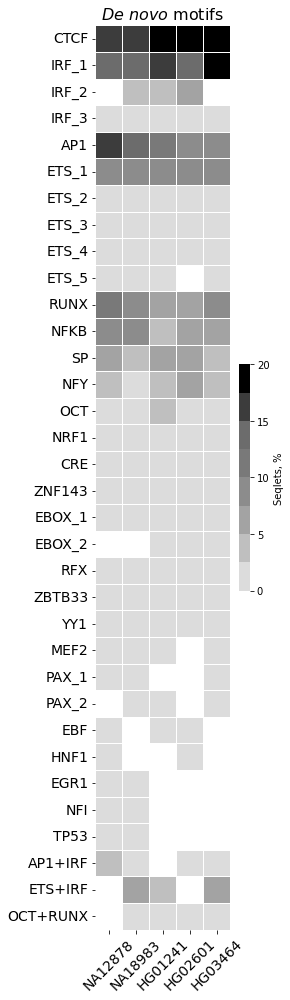

In [19]:
colors = ['gainsboro', 'darkgrey', 'grey', 'dimgrey', 'k']
cm_custom = LinearSegmentedColormap.from_list('greyscale', colors, N = 8)

plt.figure(figsize = (4, 14))
plt.title('$De$ $novo$ motifs', fontsize = 16)
sns.heatmap(motif_clusters[['fraction_NA12878', 'fraction_NA18983', 'fraction_HG01241', 'fraction_HG02601', 'fraction_HG03464']],
            cmap = cm_custom, vmin = 0, vmax = 20, linewidths = 1, cbar_kws = {'shrink': 0.25, 'ticks': [0, 5, 10, 15, 20], 'label': 'Seqlets, %'})
plt.yticks(np.arange(len(motif_clusters))+0.5, motif_clusters['cluster_name'], fontsize = 14, rotation = 0)
plt.xticks(np.arange(5)+0.5, ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'], fontsize = 14, rotation = 45)
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/chrombpnet_tfmodisco_denovo_motif_clusters.pdf', bbox_inches = 'tight')
plt.show()